In [ ]:
!pip install lightning torch-geometric torch torchvision torchaudio pandas numpy scikit-learn tqdm fastapi uvicorn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 20.2 MB/s eta 0:00:00


In [ ]:
# preprocess_all_beauty.py
# Usage: change ROOT to where your All_Beauty_5.json and meta_All_Beauty.json live,
# then run this in Colab (after mounting Drive) or locally.

import os
import json
import pickle
import random
from collections import defaultdict, Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import Data as PyGData
import networkx as nx

# ----------------- CONFIG -----------------
ROOT = "/content/drive/MyDrive/dataset Json"   # <<-- update if needed
REV_FILE = os.path.join(ROOT, "All_Beauty_5.json")
META_FILE = os.path.join(ROOT, "meta_All_Beauty.json")
OUT_DIR = ROOT

# K-core thresholds
MIN_USER_REVIEWS = 5
MIN_PRODUCT_REVIEWS = 5

RANDOM_SEED = 42
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

MAX_SEQ_WINDOW = None  # keep full per-user sequences (you can clip later)
PAD_IDX = 0

print("CONFIG:", ROOT, REV_FILE, META_FILE)

# ----------------- HELPERS -----------------
def read_json_lines(path):
    docs = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            try:
                docs.append(json.loads(line))
            except Exception:
                # skip malformed lines
                continue
    return docs

# ----------------- LOAD RAW -----------------
print("Loading reviews...")
reviews = read_json_lines(REV_FILE)    # list of dicts

print("Loading metadata...")
meta_raw = read_json_lines(META_FILE)  # list of dicts

print(f"Loaded: {len(reviews)} reviews, {len(meta_raw)} metadata entries")

# ----------------- CLEAN / NORMALIZE -----------------
# Build metadata dataframe and dictionary keyed by asin
meta_df = pd.DataFrame(meta_raw)
meta_df['asin'] = meta_df.get('asin', pd.Series([None]*len(meta_df)))
meta_df = meta_df.dropna(subset=['asin']).drop_duplicates(subset=['asin']).reset_index(drop=True)
meta_df['asin'] = meta_df['asin'].astype(str)
meta_df.fillna("", inplace=True)
meta_df.set_index('asin', inplace=True, drop=False)
meta = meta_df.to_dict(orient='index')  # asin -> dict

# Clean reviews: require reviewerID, asin, unixReviewTime
cleaned = []
for r in reviews:
    if not r:
        continue
    if 'reviewerID' not in r or 'asin' not in r or ('unixReviewTime' not in r and 'reviewTime' not in r):
        continue
    reviewer = str(r.get('reviewerID'))
    asin = str(r.get('asin'))
    # prefer unixReviewTime if present
    t = r.get('unixReviewTime')
    if t is None:
        # attempt to parse reviewTime as fallback (not ideal)
        try:
            # many reviewTimes like "12 3, 2012" — skip if not parseable
            t = int(pd.to_datetime(r.get('reviewTime')).timestamp())
        except Exception:
            t = 0
    try:
        rating = float(r.get('overall', 0.0))
    except Exception:
        rating = 0.0
    text = (r.get('reviewText') or "") + " " + (r.get('summary') or "")
    cleaned.append({'reviewerID': reviewer, 'asin': asin, 'time': int(t), 'rating': rating, 'text': text.strip()})

print("Cleaned reviews:", len(cleaned))

# ----------------- K-CORE FILTERING -----------------
def k_core_filter(recs, min_u, min_i):
    # recs: list of dicts with reviewerID & asin
    user_counts = Counter([r['reviewerID'] for r in recs])
    prod_counts = Counter([r['asin'] for r in recs])
    removed = True
    recs_cur = recs
    iteration = 0
    while removed:
        iteration += 1
        removed = False
        users_keep = {u for u, c in user_counts.items() if c >= min_u}
        prods_keep = {p for p, c in prod_counts.items() if c >= min_i}
        # filter
        new = []
        for r in recs_cur:
            if r['reviewerID'] in users_keep and r['asin'] in prods_keep:
                new.append(r)
        if len(new) != len(recs_cur):
            removed = True
            recs_cur = new
            user_counts = Counter([r['reviewerID'] for r in recs_cur])
            prod_counts = Counter([r['asin'] for r in recs_cur])
    print(f"K-core done (iter={iteration}): users={len(user_counts)} products={len(prod_counts)} interactions={len(recs_cur)}")
    return recs_cur, user_counts, prod_counts

filtered_reviews, user_counts, prod_counts = k_core_filter(cleaned, MIN_USER_REVIEWS, MIN_PRODUCT_REVIEWS)

# ----------------- BUILD MAPPINGS -----------------
# We'll map products to indices 1..N (0 reserved for padding)
asins = sorted(list(prod_counts.keys()))
num_products = len(asins)
print("Products after k-core:", num_products)

asin_to_idx = {asin: idx+1 for idx, asin in enumerate(asins)}  # 1..N
idx_to_asin = {v:k for k,v in asin_to_idx.items()}

# map users to indices 1..M
users = sorted(list({r['reviewerID'] for r in filtered_reviews}))
user_to_idx = {u: i+1 for i,u in enumerate(users)}
idx_to_user = {v:k for k,v in user_to_idx.items()}

num_users = len(users)
print("Users after k-core:", num_users)

# ----------------- BUILD USER SEQUENCES -----------------
# For each user, collect interactions sorted by time
user_seqs = {}
user_timestamps = {}
user_ratings = {}
for r in filtered_reviews:
    uid = user_to_idx[r['reviewerID']]
    pid = asin_to_idx[r['asin']]
    t = r['time']
    rt = r['rating']
    if uid not in user_seqs:
        user_seqs[uid] = []
        user_timestamps[uid] = []
        user_ratings[uid] = []
    user_seqs[uid].append(pid)
    user_timestamps[uid].append(t)
    user_ratings[uid].append(rt)

# sort each user's sequence chronologically by timestamp
for uid in list(user_seqs.keys()):
    times = user_timestamps[uid]
    order = np.argsort(times)
    user_seqs[uid] = [user_seqs[uid][i] for i in order]
    user_timestamps[uid] = [times[i] for i in order]
    user_ratings[uid] = [user_ratings[uid][i] for i in order]

# Save user_sequences.pkl
user_sequences = {'sequences': user_seqs, 'timestamps': user_timestamps, 'ratings': user_ratings}
with open(os.path.join(OUT_DIR, "user_sequences1.pkl"), "wb") as f:
    pickle.dump(user_sequences, f)
print("Saved user_sequences1.pkl")

# ----------------- BUILD GRAPH -----------------
# Start with NetworkX graph where nodes are product indices 1..N
G = nx.Graph()
G.add_nodes_from(range(1, num_products+1))

# Add edges from metadata fields: also_buy, also_view, bought_together if present
for asin, info in meta.items():
    if asin not in asin_to_idx:
        continue
    i = asin_to_idx[asin]
    # helper to push edges if target in mapping
    def add_list_field(field):
        items = info.get(field, [])
        if isinstance(items, str):
            # sometimes string; skip
            return
        for other in items:
            other = str(other)
            if other in asin_to_idx:
                j = asin_to_idx[other]
                if i != j:
                    G.add_edge(i, j, rel=field)

    add_list_field('also_buy')
    add_list_field('also_view')
    # some scraped meta have 'bought_together' or 'also_bought' etc
    add_list_field('also_bought')
    add_list_field('bought_together')
    add_list_field('similar_item')

# Add co-purchase edges from user sequences: for each user, connect consecutive items in sessions
for uid, seq in user_seqs.items():
    for a,b in zip(seq, seq[1:]):
        if a != b:
            G.add_edge(a, b, rel='copurchase')

# Convert to PyG edge_index (2 x E), undirected edges as both directions
edges = list(G.edges())
edge_index = []
for u,v in edges:
    edge_index.append((u, v))
    edge_index.append((v, u))
if len(edge_index) == 0:
    edge_index = [(1,1)]  # fallback self-edge
edge_index = np.array(edge_index).T  # shape (2, E)
print("Graph nodes:", G.number_of_nodes(), "edges (sym):", edge_index.shape[1])

# Save graph stats optionally
graph_stats = {
    'nodes': G.number_of_nodes(),
    'edges': G.number_of_edges(),
    'avg_degree': np.mean([d for _,d in G.degree()]) if G.number_of_nodes()>0 else 0,
}
with open(os.path.join(OUT_DIR, "graph_stats1.pkl"), "wb") as f:
    pickle.dump(graph_stats, f)

# ----------------- BUILD PRODUCT FEATURES (TF-IDF + numeric) -----------------
# We'll build a textual field by concatenating title, description, brand, features
texts = []
asins_in_order = []
for idx in range(1, num_products+1):
    asin = idx_to_asin[idx]
    info = meta.get(asin, {})
    title = info.get('title', '') or ''
    desc_list = info.get('description', '') or []
    if isinstance(desc_list, list):
        desc = " ".join(desc_list)
    else:
        desc = str(desc_list)
    brand = info.get('brand', '') or ''
    features = " ".join(info.get('feature', []) if isinstance(info.get('feature', []), list) else [str(info.get('feature', ''))])
    text = " ".join([title, desc, brand, features])
    texts.append(text)
    asins_in_order.append(asin)

# TF-IDF on product text (limit features for small dataset)
tf = TfidfVectorizer(max_features=1024, ngram_range=(1,2), stop_words='english')
tfidf = tf.fit_transform(texts)  # shape (num_products, feat)
tfidf = tfidf.astype(np.float32)

# Numeric features: price (try to parse), rank (try to numeric), image presence
num_feats = []
for asin in asins_in_order:
    info = meta.get(asin, {})
    # price
    p = info.get('price', "") or ""
    price_val = 0.0
    if isinstance(p, (int, float)):
        price_val = float(p)
    else:
        try:
            # remove $ and commas
            p2 = str(p).replace('$','').replace(',','').strip()
            price_val = float(p2) if p2!="" else 0.0
        except Exception:
            price_val = 0.0
    # rank: remove non-digits
    rank = info.get('rank', "") or ""
    rank_val = 0.0
    try:
        # find first number sequence
        import re
        m = re.search(r'[\d,]+', str(rank))
        if m:
            rank_val = float(m.group(0).replace(',',''))
    except Exception:
        rank_val = 0.0
    # image presence
    image = info.get('imageURLHighRes', []) or info.get('imageURL', [])
    img_flag = 1.0 if (isinstance(image, list) and len(image)>0) or (isinstance(image, str) and image.strip()!='') else 0.0
    num_feats.append([price_val, rank_val, img_flag])

num_feats = np.array(num_feats, dtype=np.float32)

# standardize numeric features
scaler = StandardScaler()
if num_feats.shape[0] > 0:
    num_feats_scaled = scaler.fit_transform(num_feats)
else:
    num_feats_scaled = num_feats

# Combine TF-IDF and numeric into final feature matrix
from scipy.sparse import hstack
features_sparse = hstack([tfidf, sparse.csr_matrix(num_feats_scaled)])  # (num_products, feat_dim)
features_matrix = features_sparse.toarray().astype(np.float32)  # dense for small dataset
feature_dim = features_matrix.shape[1]

# Build product_features dict mapping asin -> vector
asin_to_features = {asin: features_matrix[i].tolist() for i, asin in enumerate(asins_in_order)}

product_features = {
    'features_matrix': features_matrix,         # numpy array (num_products x feat_dim)
    'asin_to_features': asin_to_features,       # dict
    'asins': asins_in_order,                    # aligned list
    'vectorizer': tf,                           # sklearn vectorizer (picklable)
    'scaler': scaler,                           # numeric scaler
    'feature_dim': feature_dim
}

with open(os.path.join(OUT_DIR, "product_features1.pkl"), "wb") as f:
    pickle.dump(product_features, f)
print("Saved product_features1.pkl (shape = {})".format(features_matrix.shape))

# ----------------- BUILD EXAMPLES (train/val/test) -----------------
# For each user's sequence, create training examples: (user_idx, prefix_seq, target_item)
examples = []
for uid, seq in user_seqs.items():
    L = len(seq)
    # generate for each prefix where there is a next item
    for i in range(1, L):
        prefix = seq[:i]  # list of item indices
        target = seq[i]   # next item index
        examples.append((uid, prefix, target))

print("Total examples generated:", len(examples))

# Shuffle and split
random.seed(RANDOM_SEED)
random.shuffle(examples)
n = len(examples)
n_train = int(n * TRAIN_RATIO)
n_val = int(n * VAL_RATIO)
train_ex = examples[:n_train]
val_ex = examples[n_train:n_train+n_val]
test_ex = examples[n_train+n_val:]

splits_final = {'train': train_ex, 'val': val_ex, 'test': test_ex, 'item_popularity': np.array([prod_counts.get(a,0) for a in asins])}
with open(os.path.join(OUT_DIR, "splits_final1.pkl"), "wb") as f:
    pickle.dump(splits_final, f)
print("Saved splits_final1.pkl: train", len(train_ex), "val", len(val_ex), "test", len(test_ex))

# ----------------- BUILD PYTORCH GEOMETRIC PACK -----------------
# Build node_features tensor aligned with indices 1..N. We will prepend a PAD row at index 0
pad_row = np.zeros((1, feature_dim), dtype=np.float32)
node_feat_matrix = np.vstack([pad_row, features_matrix])  # shape (num_products+1, feat_dim)

node_features_tensor = torch.tensor(node_feat_matrix, dtype=torch.float32)

# Edge index: our edge_index currently uses node indices 1..N
edge_idx = torch.tensor(edge_index, dtype=torch.long)  # shape (2, E)

# Create a PyG Data object — note: PyG expects 0..N-1 nodes, but we have 0..N with pad at 0.
# To keep indexing consistent with training code (which expects 1..N with pad=0), we will store as-is.
pyg_data = PyGData(x=node_features_tensor, edge_index=edge_idx)

# Create sequences dict mapping user_idx -> list of item indices (as ints)
sequences_serializable = {int(k): [int(x) for x in v] for k, v in user_seqs.items()}

pytorch_pack = {
    'sequences': sequences_serializable,
    'graph': {'edge_index': edge_index, 'nx_graph': nx.to_dict_of_lists(G)},  # keep minimal graph info
    'pyg_data': pyg_data,
    'node_features': node_features_tensor
}

torch.save(pytorch_pack, os.path.join(OUT_DIR, "pytorch_data1.pt"))
print("Saved pytorch_data1.pt")

# ----------------- SAVE MAPPINGS -----------------
mappings = {
    'user_to_idx': user_to_idx,
    'idx_to_user': idx_to_user,
    'product_to_idx': asin_to_idx,
    'idx_to_product': idx_to_asin,
    'num_users': num_users,
    'num_products': num_products
}
with open(os.path.join(OUT_DIR, "mappings1.pkl"), "wb") as f:
    pickle.dump(mappings, f)
print("Saved mappings1.pkl")

# ----------------- SAVE USER SEQUENCES ALREADY SAVED ABOVE -----------------
# Saves: user_sequences.pkl, product_features.pkl, splits_final.pkl, pytorch_data.pt, mappings.pkl

print("ALL DONE. Files saved to:", OUT_DIR)
print("Mappings: num_users=", num_users, " num_products=", num_products)


CONFIG: /content/drive/MyDrive/dataset Json /content/drive/MyDrive/dataset Json/All_Beauty_5.json /content/drive/MyDrive/dataset Json/meta_All_Beauty.json
Loading reviews...
Loading metadata...
Loaded: 5269 reviews, 32892 metadata entries
Cleaned reviews: 5269
K-core done (iter=5): users=961 products=49 interactions=5084
Products after k-core: 49
Users after k-core: 961
Saved user_sequences1.pkl
Graph nodes: 49 edges (sym): 230
Saved product_features1.pkl (shape = (49, 1027))
Total examples generated: 4123
Saved splits_final1.pkl: train 2886 val 412 test 825
Saved pytorch_data1.pt
Saved mappings1.pkl
ALL DONE. Files saved to: /content/drive/MyDrive/dataset Json
Mappings: num_users= 961  num_products= 49


In [ ]:
!ls -lh /content/drive/MyDrive/dataset\ Json


total 96M
-rw------- 1 root root 2.4M Nov 11 18:00 All_Beauty_5.json
-rw------- 1 root root 1.4M Nov 11 18:00 All_Beauty_5.pkl
drwx------ 2 root root 4.0K Nov 12 09:47 checkpoints
-rw------- 1 root root  698 Nov 11 18:00 dataset_config.json
-rw------- 1 root root  600 Nov 11 18:00 dataset_config.pkl
-rw------- 1 root root   89 Nov 11 18:00 dataset_stats.pkl
-rw------- 1 root root 1.6M Nov 15 12:05 fsgan_model_bundle.pt
-rw------- 1 root root  154 Nov 15 16:37 graph_stats1.pkl
-rw------- 1 root root  154 Nov 15 16:35 graph_stats.pkl
-rw------- 1 root root 219K Nov 11 18:00 iltered_All_Beauty_5.pkl
-rw------- 1 root root  33K Nov 11 18:00 iltered_meta_All_Beauty_5.pkl
-rw------- 1 root root  26K Nov 15 16:37 mappings1.pkl
-rw------- 1 root root  26K Nov 15 16:35 mappings.pkl
-rw------- 1 root root  64M Nov 11 18:00 meta_All_Beauty.json
-rw------- 1 root root  25M Nov 11 18:00 meta_All_Beauty.pkl
-rw------- 1 root root 681K Nov 15 16:37 product_features1.pkl
-rw------- 1 root root 681K No

In [ ]:
# full_advanced_hybrid.py
# End-to-end training + inference script (robust / padding-aligned / item+user fusion)
import os, pickle, random, math, sys, time
from typing import List, Optional, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from tqdm import tqdm

# ---------------- CONFIG ----------------
DATA_DIR = "/content/drive/MyDrive/dataset Json"   # <- adjust if needed
# try to use the '1' (full) variants if present, else fall back
PT_CANDIDATES = ["pytorch_data1.pt", "pytorch_data.pt"]
MAP_CANDIDATES = ["mappings1.pkl", "mappings.pkl"]
SPLIT_CANDIDATES = ["splits_final1.pkl", "splits_final.pkl"]
PROD_FEAT_CANDIDATES = ["product_features1.pkl", "product_features.pkl"]
BUNDLE_OUT = os.path.join(DATA_DIR, "fsgan_model_bundle_final.pt")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

EMBED_DIM = 128
SEQ_HIDDEN = 128
GAT_HIDDEN = 128
FEAT_HIDDEN = 128
FUSE_HIDDEN = 192

BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
WEIGHT_DECAY = 1e-5
GRAD_CLIP = 5.0
MAX_SEQ_LEN = 50
TOP_K = [5, 10]

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ---------------- helpers to pick files ----------------
def pick_first_exist(base_dir, candidates):
    for c in candidates:
        p = os.path.join(base_dir, c)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"None of {candidates} found in {base_dir}")

PT_PATH = pick_first_exist(DATA_DIR, PT_CANDIDATES)
MAPPINGS_PATH = pick_first_exist(DATA_DIR, MAP_CANDIDATES)
SPLITS_PATH = pick_first_exist(DATA_DIR, SPLIT_CANDIDATES)
PRODUCT_FEATURES_PATH = pick_first_exist(DATA_DIR, PROD_FEAT_CANDIDATES)

print("CONFIG:", PT_PATH, MAPPINGS_PATH, SPLITS_PATH, PRODUCT_FEATURES_PATH, "-> out:", BUNDLE_OUT)

# ---------------- Dataset wrapper ----------------
class UserSeqDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        # unwrap shapes (some saved examples are wrapped)
        if isinstance(ex, tuple) and len(ex) == 1 and isinstance(ex[0], tuple):
            ex = ex[0]
        if not isinstance(ex, tuple) or len(ex) < 3:
            return torch.zeros(MAX_SEQ_LEN, dtype=torch.long), torch.tensor(0, dtype=torch.long)
        user, seq, target = ex[:3]
        if not isinstance(seq, list):
            seq = list(seq) if seq else []
        seq = seq[-MAX_SEQ_LEN:]
        seq = [0] * (MAX_SEQ_LEN - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def collate_fn(batch):
    seqs = torch.stack([b[0] for b in batch])
    targets = torch.stack([b[1] for b in batch])
    return seqs, targets

# ---------------- Model components ----------------
class SeqEncoder(nn.Module):
    def __init__(self, num_items, emb_dim=EMBED_DIM, hidden=SEQ_HIDDEN):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(0.1)
    def forward(self, seqs):
        emb = self.item_emb(seqs)
        _, h = self.gru(emb)
        return self.drop(h.squeeze(0))

class ItemGAT(nn.Module):
    def __init__(self, num_items, in_dim, hid_dim=GAT_HIDDEN):
        super().__init__()
        self.id_emb = nn.Embedding(num_items + 1, hid_dim, padding_idx=0)
        nn.init.uniform_(self.id_emb.weight, -0.01, 0.01)
        self.gat1 = GATConv(in_dim, hid_dim, heads=4, concat=False)
        self.gat2 = GATConv(hid_dim, hid_dim, heads=4, concat=False)
        self.ffn = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim)
        )
        for p in self.ffn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    def forward(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = F.elu(self.gat2(h, edge_index))
        h = F.layer_norm(h, h.shape[1:])
        ids = torch.arange(h.size(0), device=h.device)
        h = h + self.id_emb(ids)
        h_ffn = self.ffn(h)
        h = h + 0.1 * h_ffn
        h = F.layer_norm(h, h.shape[1:])
        return h             # (num_nodes, hid_dim)

class ProductFeatEncoder(nn.Module):
    def __init__(self, in_dim, hid=FEAT_HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid)
        )
        for p in self.net.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
    def forward(self, feat):
        out = self.net(feat)
        return F.layer_norm(out, out.shape[1:])

class AdvancedFSGAN(nn.Module):
    def __init__(self, num_items, node_feat_dim, prod_feat_dim):
        super().__init__()
        self.seq_enc = SeqEncoder(num_items)
        self.gat = ItemGAT(num_items, node_feat_dim, GAT_HIDDEN)
        self.feat_enc = ProductFeatEncoder(prod_feat_dim, FEAT_HIDDEN)
        fused_dim = SEQ_HIDDEN + GAT_HIDDEN + FEAT_HIDDEN
        self.fuse = nn.Sequential(
            nn.Linear(fused_dim, FUSE_HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(FUSE_HIDDEN, FUSE_HIDDEN//2),
            nn.ReLU()
        )
        self.scorer = nn.Linear(FUSE_HIDDEN//2, num_items + 1)
        nn.init.xavier_uniform_(self.scorer.weight)
    def forward(self, seqs, node_feats, prod_feats, edge_index):
        user_state = self.seq_enc(seqs)                       # (B, SEQ_HIDDEN)
        item_graph_emb = self.gat(node_feats, edge_index)     # (num_nodes, GAT_HIDDEN)
        # prod_feats aligned to same rows as node_feats
        item_feat_emb = self.feat_enc(prod_feats)             # (num_nodes, FEAT_HIDDEN)
        graph_state = item_graph_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        feat_state = item_feat_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        fused = torch.cat([user_state, graph_state, feat_state], dim=1)
        fused = self.fuse(fused)
        logits = self.scorer(fused)
        return logits, item_graph_emb, item_feat_emb

# ---------------- training helpers ----------------
def topk_recall(logits, targets, k):
    _, topk = torch.topk(logits, k=k, dim=1)
    hits = (topk == targets.view(-1,1)).any(dim=1).float()
    if hits.numel() == 0:
        return 0.0
    return hits.mean().item()

# ---------------- load all processed ----------------
def load_processed():
    print("Loading dataset files from", DATA_DIR)
    data = torch.load(PT_PATH, map_location="cpu", weights_only=False)
    with open(MAPPINGS_PATH, "rb") as f:
        mappings = pickle.load(f)
    with open(SPLITS_PATH, "rb") as f:
        splits = pickle.load(f)
    with open(PRODUCT_FEATURES_PATH, "rb") as f:
        product_features = pickle.load(f)
    return data, mappings, splits, product_features

# ---------------- main train function ----------------
def train():
    data, mappings, splits, product_features = load_processed()
    pyg = data["pyg_data"]
    node_features = data["node_features"]   # keep on cpu for now

    num_items = int(mappings["num_products"])   # number of actual products (e.g. 49)
    idx2prod = mappings["idx_to_product"]
    prod2idx = mappings["product_to_idx"]

    # ---- ALIGNMENT: node_features must be (num_items+1, dim) i.e. include padding row at index 0 ----
    if node_features.size(0) == num_items:
        # if missing padding row, prepend one
        pad = torch.zeros(1, node_features.size(1), dtype=node_features.dtype)
        node_features = torch.cat([pad, node_features], dim=0)
        print("Prepended padding row to node_features ->", node_features.shape)
    elif node_features.size(0) == num_items + 1:
        print("Node features already include padding row ->", node_features.shape)
    else:
        raise RuntimeError(f"Unexpected node_features rows={node_features.size(0)} vs num_items={num_items}")

    # ---- BUILD prod_feats aligned to node_features (WITH padding row at index 0) ----
    if isinstance(product_features, dict):
        first_vec = next(iter(product_features.values()))
        feat_dim = len(first_vec)
        feat_list = []
        feat_list.append([0.0] * feat_dim)   # index 0 padding
        for idx in range(1, num_items + 1):
            asin = idx2prod.get(idx)
            if (asin is not None) and (asin in product_features):
                vec = product_features[asin]
                feat_list.append([float(x) for x in vec])
            else:
                feat_list.append([0.0] * feat_dim)
        prod_feats = torch.tensor(feat_list, dtype=torch.float32)
    else:
        # array-like; ensure it has padding row
        prod_feats = torch.tensor(product_features, dtype=torch.float32)
        if prod_feats.size(0) == num_items:
            pad_pf = torch.zeros(1, prod_feats.size(1), dtype=prod_feats.dtype)
            prod_feats = torch.cat([pad_pf, prod_feats], dim=0)

    # final check
    if node_features.size(0) != prod_feats.size(0):
        raise RuntimeError(f"Shape mismatch: node_features rows={node_features.size(0)} but prod_feats rows={prod_feats.size(0)}")

    # ---- Clean edges (remove any referencing 0 if present) ----
    edge_index = pyg.edge_index.clone()
    mask = (edge_index[0] != 0) & (edge_index[1] != 0)
    if mask.sum().item() < edge_index.size(1):
        edge_index = edge_index[:, mask]
        print("Filtered out edges touching padding index 0; new edge count =", edge_index.size(1))
    else:
        print("No edges touched padding index 0 (or already cleaned).")

    # move to device
    node_features = node_features.to(DEVICE)
    prod_feats = prod_feats.to(DEVICE)
    edge_index = edge_index.to(DEVICE)

    # splits
    train_ex = splits.get("train", splits.get("train_examples", []))
    val_ex = splits.get("val", splits.get("val_examples", []))
    test_ex = splits.get("test", splits.get("test_examples", []))

    print(f"num_items={num_items}; train={len(train_ex)} val={len(val_ex)} test={len(test_ex)}")
    print(f"node_features.shape={node_features.shape} prod_feats.shape={prod_feats.shape}")

    train_loader = DataLoader(UserSeqDataset(train_ex), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(UserSeqDataset(val_ex), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(UserSeqDataset(test_ex), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = AdvancedFSGAN(num_items=num_items, node_feat_dim=node_features.size(1), prod_feat_dim=prod_feats.size(1)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean")

    # remove old bundle to avoid mismatch
    try:
        if os.path.exists(BUNDLE_OUT): os.remove(BUNDLE_OUT)
    except: pass

    best_val = -1.0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0.0
        total_examples = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
        for seqs, targets in loop:
            seqs = seqs.to(DEVICE); targets = targets.to(DEVICE)
            optimizer.zero_grad()
            logits, _, _ = model(seqs, node_features, prod_feats, edge_index)

            valid_mask = (targets != 0)
            if valid_mask.sum() == 0:
                continue
            logits_valid = logits[valid_mask]
            targets_valid = targets[valid_mask]

            logits_valid = torch.nan_to_num(logits_valid, nan=0.0, posinf=1e6, neginf=-1e6)
            loss = criterion(logits_valid, targets_valid)
            if torch.isnan(loss) or torch.isinf(loss):
                print("Skipping batch with invalid loss")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            total_loss += loss.item() * logits_valid.size(0)
            total_examples += logits_valid.size(0)

        avg_loss = total_loss / (total_examples + 1e-12)

        # validation
        model.eval()
        recalls = {k:0.0 for k in TOP_K}; n_val = 0
        with torch.no_grad():
            for seqs, targets in val_loader:
                seqs = seqs.to(DEVICE); targets = targets.to(DEVICE)
                logits, _, _ = model(seqs, node_features, prod_feats, edge_index)
                valid_mask = (targets != 0)
                if valid_mask.sum() == 0: continue
                l_v = logits[valid_mask]; t_v = targets[valid_mask]
                l_v[:,0] = -1e9
                for k in TOP_K:
                    recalls[k] += topk_recall(l_v, t_v, k=k) * l_v.size(0)
                n_val += l_v.size(0)
        if n_val > 0:
            for k in TOP_K: recalls[k] /= n_val
        else:
            for k in TOP_K: recalls[k] = 0.0

        print(f"Epoch {epoch}/{EPOCHS} | Loss={avg_loss:.6f} | Recall@5={recalls[5]:.4f} | Recall@10={recalls[10]:.4f}")

        if recalls[5] > best_val:
            best_val = recalls[5]
            torch.save({"model_state": model.state_dict(), "mappings": mappings}, BUNDLE_OUT)
            print("🔥 Saved best model")

    # test
    print("Loading best model for test...")
    if not os.path.exists(BUNDLE_OUT):
        print("No saved bundle found; training may have failed.")
        return
    bundle = torch.load(BUNDLE_OUT, map_location=DEVICE)
    model.load_state_dict(bundle["model_state"])
    model.eval()
    recalls = {k:0.0 for k in TOP_K}; n_test = 0
    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs = seqs.to(DEVICE); targets = targets.to(DEVICE)
            logits, item_graph_emb, item_feat_emb = model(seqs, node_features, prod_feats, edge_index)
            valid_mask = (targets != 0)
            if valid_mask.sum() == 0: continue
            l_v = logits[valid_mask]; t_v = targets[valid_mask]
            l_v[:,0] = -1e9
            for k in TOP_K:
                recalls[k] += topk_recall(l_v, t_v, k=k) * l_v.size(0)
            n_test += l_v.size(0)
    if n_test > 0:
        for k in TOP_K: recalls[k] /= n_test
    print(f"📊 Test Recall@5={recalls[5]:.4f} | Recall@10={recalls[10]:.4f}")

# ---------------- inference helpers (after training or with saved bundle) ----------------
def load_bundle_and_data():
    data = torch.load(PT_PATH, map_location="cpu", weights_only=False)
    with open(MAPPINGS_PATH, "rb") as f:
        mappings = pickle.load(f)
    product_features = pickle.load(open(PRODUCT_FEATURES_PATH, "rb"))
    # load bundle
    if not os.path.exists(BUNDLE_OUT):
        raise FileNotFoundError("Bundle not found: " + BUNDLE_OUT)
    bundle = torch.load(BUNDLE_OUT, map_location=DEVICE)
    return data, mappings, product_features, bundle

def build_runtime_model_and_assets():
    data, mappings, product_features, bundle = load_bundle_and_data()
    pyg = data["pyg_data"]
    node_features = data["node_features"]
    num_items = int(mappings["num_products"])
    idx2prod = mappings["idx_to_product"]
    prod2idx = mappings["product_to_idx"]

    # ensure padding rows just like train()
    if node_features.size(0) == num_items:
        node_features = torch.cat([torch.zeros(1, node_features.size(1)), node_features], dim=0)
    # build prod_feats aligned with padding row
    if isinstance(product_features, dict):
        first_vec = next(iter(product_features.values()))
        feat_dim = len(first_vec)
        feat_list = [[0.0]*feat_dim]
        for idx in range(1, num_items+1):
            asin = idx2prod.get(idx)
            feat_list.append([float(x) for x in product_features.get(asin, [0.0]*feat_dim)])
        prod_feats = torch.tensor(feat_list, dtype=torch.float32)
    else:
        prod_feats = torch.tensor(product_features, dtype=torch.float32)
        if prod_feats.size(0) == num_items:
            prod_feats = torch.cat([torch.zeros(1, prod_feats.size(1)), prod_feats], dim=0)

    # edge clean
    edge_index = pyg.edge_index.clone()
    mask = (edge_index[0] != 0) & (edge_index[1] != 0)
    if mask.sum().item() < edge_index.size(1):
        edge_index = edge_index[:, mask]

    # instantiate model and load weights
    model = AdvancedFSGAN(num_items=num_items, node_feat_dim=node_features.size(1), prod_feat_dim=prod_feats.size(1)).to(DEVICE)
    model.load_state_dict(bundle["model_state"])
    model.eval()

    # move tensors to device
    node_features = node_features.to(DEVICE)
    prod_feats = prod_feats.to(DEVICE)
    edge_index = edge_index.to(DEVICE)

    runtime = {
        "data": data,
        "mappings": mappings,
        "idx2prod": idx2prod,
        "prod2idx": prod2idx,
        "model": model,
        "node_features": node_features,
        "prod_feats": prod_feats,
        "edge_index": edge_index
    }
    return runtime

def cosine_sim_matrix(A: np.ndarray, B: np.ndarray):
    # A: (n, d), B: (m, d) -> (n, m)
    An = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-9)
    Bn = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-9)
    return An.dot(Bn.T)

def recommend_user(user_raw_id: str, runtime: dict, top_k=5):
    mappings = runtime["mappings"]
    prod2idx = runtime["prod2idx"]
    idx2prod = runtime["idx2prod"]
    data = runtime["data"]
    model = runtime["model"]
    node_features = runtime["node_features"]
    prod_feats = runtime["prod_feats"]
    edge_index = runtime["edge_index"]

    user2idx = mappings["user_to_idx"]
    uid = user2idx.get(user_raw_id)
    if uid is None:
        print("User not found:", user_raw_id)
        return []

    sequences = data["sequences"]
    seq = sequences.get(uid, [])
    seq = seq[-MAX_SEQ_LEN:]
    seq = [0]*(MAX_SEQ_LEN - len(seq)) + seq
    seq_tensor = torch.tensor([seq], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        logits, item_graph_emb, item_feat_emb = model(seq_tensor, node_features, prod_feats, edge_index)
        logits = logits.cpu().numpy().squeeze()
        logits[0] = -1e9
        top_idxs = np.argsort(-logits)[:top_k]

    results = []
    for r, idx in enumerate(top_idxs, start=1):
        asin = idx2prod.get(int(idx))
        results.append((r, idx, asin, float(logits[int(idx)])))
    return results

def find_asin_by_name(name_query: str, meta_df: Optional[object]=None):
    # If you have a dataframe of metadata, pass meta_df (pandas.DataFrame)
    # otherwise this is a helper placeholder that returns None
    if meta_df is None:
        return None
    q = name_query.lower()
    matches = meta_df[meta_df["title"].str.lower().str.contains(q, na=False)]
    if matches.empty:
        return None
    return matches.iloc[0]["asin"]

def recommend_similar_by_asin(asin: str, runtime: dict, top_k=5):
    mappings = runtime["mappings"]
    idx2prod = runtime["idx2prod"]
    prod2idx = runtime["prod2idx"]
    model = runtime["model"]
    node_features = runtime["node_features"]
    prod_feats = runtime["prod_feats"]
    edge_index = runtime["edge_index"]

    # get index for asin
    idx = prod2idx.get(asin)
    if idx is None:
        print("ASIN not in mapping:", asin)
        return []

    with torch.no_grad():
        # forward pass to get item embeddings
        dummy = torch.zeros(1, MAX_SEQ_LEN, dtype=torch.long).to(DEVICE)
        logits, item_graph_emb, item_feat_emb = model(dummy, node_features, prod_feats, edge_index)

        g_emb = item_graph_emb.cpu().numpy()    # (num_items+1, dim)
        f_emb = item_feat_emb.cpu().numpy()     # (num_items+1, dim)

        # combine (concat)
        comb = np.concatenate([g_emb, f_emb], axis=1)

        # normalize
        comb_norm = comb / (np.linalg.norm(comb, axis=1, keepdims=True) + 1e-9)

        target_vec = comb_norm[int(idx)]

        # full cosine similarity
        sims = comb_norm @ target_vec
        sims[0] = -1.0   # ignore padding
        sims[int(idx)] = -1.0  # ignore itself

        # top-k
        order = np.argsort(-sims)
        out = []
        for cand in order:
            asin_cand = idx2prod.get(int(cand))
            out.append((int(cand), asin_cand, float(sims[int(cand)])))
            if len(out) >= top_k:
                break

        return out


# ---------------- run helpers ----------------
if __name__ == "__main__":
    # Train (uncomment to train). Training can be long; ensure you want to run it.
    print("Starting training run (call train()) if you want. To train set train() call.")
    train()            # <-- uncomment to run training immediately

    # Example: after training, to load runtime assets and get recommendations:
    # runtime = build_runtime_model_and_assets()
    # print(recommend_user(list(runtime['mappings']['user_to_idx'].keys())[0], runtime, top_k=5))


CONFIG: /content/drive/MyDrive/dataset Json/pytorch_data1.pt /content/drive/MyDrive/dataset Json/mappings1.pkl /content/drive/MyDrive/dataset Json/splits_final1.pkl /content/drive/MyDrive/dataset Json/product_features1.pkl -> out: /content/drive/MyDrive/dataset Json/fsgan_model_bundle_final.pt
Starting training run (call train()) if you want. To train set train() call.
Loading dataset files from /content/drive/MyDrive/dataset Json
Node features already include padding row -> torch.Size([50, 1027])
No edges touched padding index 0 (or already cleaned).
num_items=49; train=2886 val=412 test=825
node_features.shape=torch.Size([50, 1027]) prod_feats.shape=torch.Size([50, 49])


Epoch 1/30: 100%|██████████| 46/46 [00:03<00:00, 12.01it/s]


Epoch 1/30 | Loss=1.493793 | Recall@5=0.9053 | Recall@10=0.9369
🔥 Saved best model


Epoch 2/30: 100%|██████████| 46/46 [00:03<00:00, 12.94it/s]


Epoch 2/30 | Loss=0.620543 | Recall@5=0.9345 | Recall@10=0.9515
🔥 Saved best model


Epoch 3/30: 100%|██████████| 46/46 [00:04<00:00,  9.50it/s]


Epoch 3/30 | Loss=0.531693 | Recall@5=0.9490 | Recall@10=0.9587
🔥 Saved best model


Epoch 4/30: 100%|██████████| 46/46 [00:03<00:00, 12.69it/s]


Epoch 4/30 | Loss=0.471804 | Recall@5=0.9563 | Recall@10=0.9636
🔥 Saved best model


Epoch 5/30: 100%|██████████| 46/46 [00:03<00:00, 13.02it/s]


Epoch 5/30 | Loss=0.419532 | Recall@5=0.9587 | Recall@10=0.9709
🔥 Saved best model


Epoch 6/30: 100%|██████████| 46/46 [00:04<00:00, 10.82it/s]


Epoch 6/30 | Loss=0.387839 | Recall@5=0.9612 | Recall@10=0.9709
🔥 Saved best model


Epoch 7/30: 100%|██████████| 46/46 [00:04<00:00, 11.12it/s]


Epoch 7/30 | Loss=0.361581 | Recall@5=0.9660 | Recall@10=0.9733
🔥 Saved best model


Epoch 8/30: 100%|██████████| 46/46 [00:03<00:00, 12.84it/s]


Epoch 8/30 | Loss=0.353295 | Recall@5=0.9612 | Recall@10=0.9757


Epoch 9/30: 100%|██████████| 46/46 [00:03<00:00, 12.55it/s]


Epoch 9/30 | Loss=0.333800 | Recall@5=0.9660 | Recall@10=0.9733


Epoch 10/30: 100%|██████████| 46/46 [00:04<00:00,  9.63it/s]


Epoch 10/30 | Loss=0.313604 | Recall@5=0.9563 | Recall@10=0.9782


Epoch 11/30: 100%|██████████| 46/46 [00:03<00:00, 12.53it/s]


Epoch 11/30 | Loss=0.307224 | Recall@5=0.9636 | Recall@10=0.9782


Epoch 12/30: 100%|██████████| 46/46 [00:03<00:00, 12.90it/s]


Epoch 12/30 | Loss=0.295598 | Recall@5=0.9612 | Recall@10=0.9806


Epoch 13/30: 100%|██████████| 46/46 [00:04<00:00,  9.78it/s]


Epoch 13/30 | Loss=0.284911 | Recall@5=0.9660 | Recall@10=0.9830


Epoch 14/30: 100%|██████████| 46/46 [00:03<00:00, 12.48it/s]


Epoch 14/30 | Loss=0.282414 | Recall@5=0.9612 | Recall@10=0.9806


Epoch 15/30: 100%|██████████| 46/46 [00:03<00:00, 12.89it/s]


Epoch 15/30 | Loss=0.269192 | Recall@5=0.9612 | Recall@10=0.9733


Epoch 16/30: 100%|██████████| 46/46 [00:05<00:00,  8.84it/s]


Epoch 16/30 | Loss=0.263795 | Recall@5=0.9660 | Recall@10=0.9830


Epoch 17/30: 100%|██████████| 46/46 [00:03<00:00, 11.65it/s]


Epoch 17/30 | Loss=0.253761 | Recall@5=0.9587 | Recall@10=0.9854


Epoch 18/30: 100%|██████████| 46/46 [00:03<00:00, 12.99it/s]


Epoch 18/30 | Loss=0.247644 | Recall@5=0.9733 | Recall@10=0.9830
🔥 Saved best model


Epoch 19/30: 100%|██████████| 46/46 [00:03<00:00, 12.05it/s]


Epoch 19/30 | Loss=0.253770 | Recall@5=0.9709 | Recall@10=0.9854


Epoch 20/30: 100%|██████████| 46/46 [00:04<00:00,  9.94it/s]


Epoch 20/30 | Loss=0.231953 | Recall@5=0.9709 | Recall@10=0.9879


Epoch 21/30: 100%|██████████| 46/46 [00:03<00:00, 12.48it/s]


Epoch 21/30 | Loss=0.227495 | Recall@5=0.9709 | Recall@10=0.9854


Epoch 22/30: 100%|██████████| 46/46 [00:05<00:00,  9.08it/s]


Epoch 22/30 | Loss=0.228307 | Recall@5=0.9709 | Recall@10=0.9854


Epoch 23/30: 100%|██████████| 46/46 [00:04<00:00,  9.87it/s]


Epoch 23/30 | Loss=0.222924 | Recall@5=0.9733 | Recall@10=0.9879


Epoch 24/30: 100%|██████████| 46/46 [00:03<00:00, 13.03it/s]


Epoch 24/30 | Loss=0.211888 | Recall@5=0.9757 | Recall@10=0.9903
🔥 Saved best model


Epoch 25/30: 100%|██████████| 46/46 [00:03<00:00, 13.08it/s]


Epoch 25/30 | Loss=0.206538 | Recall@5=0.9709 | Recall@10=0.9854


Epoch 26/30: 100%|██████████| 46/46 [00:04<00:00,  9.26it/s]


Epoch 26/30 | Loss=0.208828 | Recall@5=0.9733 | Recall@10=0.9903


Epoch 27/30: 100%|██████████| 46/46 [00:03<00:00, 12.79it/s]


Epoch 27/30 | Loss=0.205734 | Recall@5=0.9733 | Recall@10=0.9903


Epoch 28/30: 100%|██████████| 46/46 [00:03<00:00, 12.53it/s]


Epoch 28/30 | Loss=0.203205 | Recall@5=0.9733 | Recall@10=0.9879


Epoch 29/30: 100%|██████████| 46/46 [00:04<00:00, 10.52it/s]


Epoch 29/30 | Loss=0.207239 | Recall@5=0.9757 | Recall@10=0.9903


Epoch 30/30: 100%|██████████| 46/46 [00:03<00:00, 11.55it/s]


Epoch 30/30 | Loss=0.204250 | Recall@5=0.9709 | Recall@10=0.9854
Loading best model for test...
📊 Test Recall@5=0.9709 | Recall@10=0.9794


In [ ]:
# inference_full_recommenders.py
# Paste & run in Colab (adjust DATA_DIR and filenames if necessary)

import os
import torch
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple
import json # Added to handle JSON loading

# ---------------- CONFIG - edit these to match your Colab paths ----------------
DATA_DIR = "/content/drive/MyDrive/dataset Json"   # change if needed
PT_DATA = os.path.join(DATA_DIR, "pytorch_data1.pt")      # or pytorch_data.pt
MAPPINGS = os.path.join(DATA_DIR, "mappings1.pkl")        # or mappings.pkl
PRODUCT_FEATURES = os.path.join(DATA_DIR, "product_features1.pkl")
BUNDLE_PATH = os.path.join(DATA_DIR, "fsgan_model_bundle_final.pt")  # final model bundle used in training
META_PATH_JSON = os.path.join(DATA_DIR, "meta_All_Beauty.json") # Path to metadata JSON

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_K = 10
PAD_IDX = 0
MAX_SEQ_LEN = 50

# ------------------- Helper: model class (must match training model) --------------
# Recreate the AdvancedFSGAN architecture used during training.
# If you trained a different model, ensure this matches exactly.
import torch.nn as nn
from torch_geometric.nn import GATConv

EMBED_DIM = 128
SEQ_HIDDEN = 128
GAT_HIDDEN = 128
FEAT_HIDDEN = 128
FUSE_HIDDEN = 192
DROP_RATE = 0.3

class SeqEncoder(nn.Module):
    def __init__(self, num_items, emb_dim=EMBED_DIM, hidden=SEQ_HIDDEN):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(0.1)
    def forward(self, seqs):
        emb = self.item_emb(seqs)
        _, h = self.gru(emb)
        return self.drop(h.squeeze(0))

class ItemGAT(nn.Module):
    def __init__(self, num_items, in_dim, hid_dim=GAT_HIDDEN):
        super().__init__()
        self.id_emb = nn.Embedding(num_items + 1, hid_dim, padding_idx=PAD_IDX)
        nn.init.uniform_(self.id_emb.weight, -0.01, 0.01)
        self.gat1 = GATConv(in_dim, hid_dim, heads=4, concat=False)
        self.gat2 = GATConv(hid_dim, hid_dim, heads=4, concat=False)
        self.ffn = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim)
        )
        for p in self.ffn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    def forward(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = F.elu(self.gat2(h, edge_index))
        h = F.layer_norm(h, h.shape[1:])
        ids = torch.arange(h.size(0), device=h.device)
        h = h + self.id_emb(ids)
        h_ffn = self.ffn(h)
        h = h + 0.1 * h_ffn
        h = F.layer_norm(h, h.shape[1:])
        return h

class ProductFeatEncoder(nn.Module):
    def __init__(self, in_dim, hid=FEAT_HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid)
        )
        for p in self.net.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
    def forward(self, feat):
        out = self.net(feat)
        return F.layer_norm(out, out.shape[1:])

class AdvancedFSGAN(nn.Module):
    def __init__(self, num_items, node_feat_dim, prod_feat_dim):
        super().__init__()
        self.seq_enc = SeqEncoder(num_items)
        self.gat = ItemGAT(num_items, node_feat_dim, GAT_HIDDEN)
        self.feat_enc = ProductFeatEncoder(prod_feat_dim, FEAT_HIDDEN)
        fused_dim = SEQ_HIDDEN + GAT_HIDDEN + FEAT_HIDDEN
        self.fuse = nn.Sequential(
            nn.Linear(fused_dim, FUSE_HIDDEN),
            nn.ReLU(),
            nn.Dropout(DROP_RATE),
            nn.Linear(FUSE_HIDDEN, FUSE_HIDDEN//2),
            nn.ReLU()
        )
        self.scorer = nn.Linear(FUSE_HIDDEN//2, num_items + 1)
        nn.init.xavier_uniform_(self.scorer.weight)
    def forward(self, seqs, node_feats, prod_feats, edge_index):
        user_state = self.seq_enc(seqs)                       # (B, SEQ_HIDDEN)
        item_graph_emb = self.gat(node_feats, edge_index)     # (num_items+?, GAT_HIDDEN)
        item_feat_emb = self.feat_enc(prod_feats)             # (num_items+?, FEAT_HIDDEN)
        graph_state = item_graph_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        feat_state = item_feat_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        fused = torch.cat([user_state, graph_state, feat_state], dim=1)
        fused = self.fuse(fused)
        logits = self.scorer(fused)
        return logits, item_graph_emb, item_feat_emb

# ------------------- Load data & bundle -------------------
print("Loading data...")
data = torch.load(PT_DATA, map_location="cpu", weights_only=False)
with open(MAPPINGS, "rb") as f:
    mappings = pickle.load(f)

# product_features might be dict or structure; load it
with open(PRODUCT_FEATURES, "rb") as f:
    product_features = pickle.load(f)

# meta dataframe (optional) for titles / brand
meta_df = None
if os.path.exists(META_PATH_JSON):
    try:
        # Helper to read json lines (copied from preprocess_all_beauty.py)
        def read_json_lines(path):
            docs = []
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                for i, line in enumerate(f):
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        docs.append(json.loads(line))
                    except Exception:
                        continue
            return docs

        meta_raw = read_json_lines(META_PATH_JSON)
        meta_df = pd.DataFrame(meta_raw)
        meta_df['asin'] = meta_df.get('asin', pd.Series([None]*len(meta_df)))
        meta_df = meta_df.dropna(subset=['asin']).drop_duplicates(subset=['asin']).reset_index(drop=True)
        meta_df['asin'] = meta_df['asin'].astype(str)
        meta_df.fillna("", inplace=True)
        print("Loaded meta JSON (rows):", len(meta_df))
    except Exception as e:
        print("Could not load meta json:", e)

idx2prod = mappings.get("idx_to_product")
prod2idx = mappings.get("product_to_idx")
user2idx = mappings.get("user_to_idx")
idx2user = mappings.get("idx_to_user")
num_items = int(mappings.get("num_products"))

# node_features & graph
node_features = data["node_features"].clone()  # may be (num_items) or (num_items+1)
pyg = data["pyg_data"]
edge_index = pyg.edge_index.clone()

# prune or prepend padding if needed (robustness)
if node_features.size(0) == num_items:
    # training used sometimes without padding row; create consistent behavior: build prod_feats aligned to node features rows
    print("Node features rows == num_items (no explicit padding row).")
elif node_features.size(0) == num_items + 1:
    print("Node features appear to include padding row at index 0.")
else:
    print(f"Node features rows = {node_features.size(0)}, num_items = {num_items} (unexpected)")

# ------------------- Build product feature matrix aligned to idx2prod -------------------
# product_features can be:
# - dict: ASIN -> vector
# - dict-like structure with keys 'features_matrix' and 'asin_to_features' (your product_features.pkl variants)
def build_prod_feat_tensor(product_features, idx2prod, num_items, device):
    # returns prod_feats (torch.FloatTensor) aligned to idx2prod ordering
    # It will always have a padding row at index 0 and then indices 1..num_items
    if isinstance(product_features, dict) and "features_matrix" in product_features:
        # This branch handles the case where product_features is the dict from product_features1.pkl
        mat = np.array(product_features["features_matrix"]) # This matrix has num_items rows, no padding
        feat_dim = mat.shape[1]
        asins_in_order = list(product_features["asins"]) # List of ASINs aligned with mat rows
        asin2row_map = {asin: i for i, asin in enumerate(asins_in_order)}

        # Create a list of feature vectors for indices 0 to num_items
        feat_list_with_padding = []
        feat_list_with_padding.append(np.zeros(feat_dim, dtype=np.float32)) # Padding row at index 0

        for idx in range(1, num_items + 1):
            asin = idx2prod.get(idx)
            if asin in asin2row_map:
                feat_list_with_padding.append(mat[asin2row_map[asin]])
            else:
                feat_list_with_padding.append(np.zeros(feat_dim, dtype=np.float32)) # Placeholder for missing item
        return torch.tensor(np.stack(feat_list_with_padding, axis=0), dtype=torch.float32, device=device)
    else:
        # Fallback or alternative structure if product_features is not the expected dict type
        # This part might need further refinement based on actual 'product_features' content if it's not the above format.
        print("Warning: product_features format not fully supported, attempting best effort conversion.")
        # Assuming it's already a NumPy array with num_items rows
        arr = np.array(product_features['features_matrix'])
        feat_dim = arr.shape[1]
        pad_row = np.zeros((1, feat_dim), dtype=np.float32)
        return torch.tensor(np.vstack([pad_row, arr]), dtype=torch.float32, device=device)

prod_feats = build_prod_feat_tensor(product_features, idx2prod, num_items, DEVICE)

# node_features already has padding, prod_feats has padding, now align node_features to have 0...num_items+1 if it doesn't
if node_features.size(0) == num_items:
    # If node_features doesn't have a padding row, add one
    pad_node_row = torch.zeros(1, node_features.size(1), dtype=node_features.dtype, device=DEVICE)
    node_features = torch.cat([pad_node_row, node_features], dim=0)
elif node_features.size(0) != num_items + 1:
    # This case should ideally not happen if preprocessing is consistent
    raise ValueError(f"Unexpected node_features size: {node_features.size(0)}. Expected {num_items} or {num_items+1}.")

node_features = node_features.to(DEVICE)
edge_index = edge_index.to(DEVICE)

print("Shapes -> node_features:", node_features.shape, "prod_feats:", prod_feats.shape)

# ------------------- Instantiate model and load bundle -------------------
print("Constructing model...")
model = AdvancedFSGAN(num_items=num_items, node_feat_dim=node_features.size(1), prod_feat_dim=prod_feats.size(1)).to(DEVICE)

if os.path.exists(BUNDLE_PATH):
    try:
        bundle = torch.load(BUNDLE_PATH, map_location=DEVICE)
        state = bundle.get("model_state", bundle)
        # some bundles have keys like 'model_state' or are just state_dict
        model.load_state_dict(state)
        print("Loaded model bundle from", BUNDLE_PATH)
    except Exception as e:
        print("Error loading model_state:", e)
        # try strict=False to at least load matching keys
        try:
            model.load_state_dict(state, strict=False)
            print("Loaded model state with strict=False (partial).")
        except Exception as e2:
            print("Failed to load model even with strict=False:", e2)
else:
    print("Bundle not found at", BUNDLE_PATH, "-- you must set BUNDLE_PATH to your saved model.")

model.eval()

# ------------------- Utilities -------------------
def safe_topk_from_probs(probs: np.ndarray, top_k: int = 10, mask_indices: List[int] = None):
    if mask_indices is None:
        mask_indices = []
    probs = np.copy(probs)
    probs[mask_indices] = -np.inf
    idxs = np.argsort(-probs)[:top_k]
    return idxs, probs[idxs]

def get_metadata_for_asin(asin: str) -> Dict:
    # try meta_df if available otherwise return minimal info
    if meta_df is not None:
        row = meta_df[meta_df["asin"].astype(str) == str(asin)]
        if not row.empty:
            r = row.iloc[0]
            return {
                "asin": str(asin),
                "title": r.get("title", "N/A"),
                "brand": r.get("brand", "N/A"),
                "price": r.get("price", "N/A"),
                "image": r.get("imageURLHighRes", None) if "imageURLHighRes" in r.index else None
            }
    return {"asin": str(asin), "title": "Unknown", "brand": "-", "price": "-", "image": None}

# ------------------- Product name to ASIN lookup -------------------
def find_asin_by_name(name_query: str) -> str:
    q = name_query.lower().strip()
    if meta_df is not None:
        matches = meta_df[meta_df["title"].astype(str).str.lower().str.contains(q, na=False)]
        if len(matches) == 0:
            return None
        return str(matches.iloc[0]["asin"])
    # fallback: search idx2prod titles if you stored titles in product_features structure
    # If no meta available return None
    return None

# ------------------- Inference helpers -------------------
def _prepare_seq_for_user(user_raw_id: str, data, user2idx_map) -> torch.LongTensor:
    # find user index; sequences in data may be keyed by user_idx (int) or by user raw id
    uid = user2idx_map.get(user_raw_id) if isinstance(user2idx_map, dict) else None
    sequences = data.get("sequences", {})
    # sequences might map user_idx->list or map raw userid->list
    seq = None
    if uid is not None and uid in sequences:
        seq = sequences[uid]
    elif user_raw_id in sequences:
        seq = sequences[user_raw_id]
    else:
        # also try mapping idx2user reverse
        # fallback: pick empty seq
        seq = []
    seq = list(seq)[-MAX_SEQ_LEN:]
    pad = [0] * (MAX_SEQ_LEN - len(seq))
    seq = pad + seq
    return torch.tensor([seq], dtype=torch.long, device=DEVICE)

def get_model_user_logits_and_itememb(user_raw_id: str, top_k=10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns:
      logits: np array shape (num_items+1,)
      item_graph_emb: np array shape (num_items+1, GAT_HIDDEN)
      item_feat_emb: np array shape (num_items+1, FEAT_HIDDEN)
    """
    seq_tensor = _prepare_seq_for_user(user_raw_id, data, user2idx)
    with torch.no_grad():
        logits_t, item_graph_emb_t, item_feat_emb_t = model(seq_tensor, node_features, prod_feats, edge_index)
        # logits_t shape (1, num_items+1)
        logits = logits_t[0].cpu().numpy()
        item_graph_emb = item_graph_emb_t.cpu().numpy()
        item_feat_emb = item_feat_emb_t.cpu().numpy()
    return logits, item_graph_emb, item_feat_emb

# ------------------- Recommenders -------------------
def recommend_user_based(user_raw_id: str, top_k=5):
    logits, _, _ = get_model_user_logits_and_itememb(user_raw_id, top_k=top_k)
    # mask PAD index
    logits[PAD_IDX] = -np.inf
    idxs, scores = safe_topk_from_probs(logits, top_k, mask_indices=[PAD_IDX])
    results = []
    for i, idx in enumerate(idxs):
        asin = idx2prod.get(int(idx))
        results.append({ "rank": i+1, "asin": asin, "score": float(scores[i]), **get_metadata_for_asin(asin) })
    return results

def recommend_item_based_by_graph(asin: str, top_k=5):
    # compute item_graph_emb (we need embeddings independent from user -> feed dummy seq of zeros)
    dummy_seq = torch.zeros((1, MAX_SEQ_LEN), dtype=torch.long, device=DEVICE)
    with torch.no_grad():
        _, item_graph_emb_t, _ = model(dummy_seq, node_features, prod_feats, edge_index)
    item_graph_emb = item_graph_emb_t.cpu().numpy()   # shape (num_items+1, GAT_HIDDEN) OR (num_items, ...)
    # find idx of given asin
    idx = prod2idx.get(asin) if prod2idx is not None else None
    if idx is None:
        print("ASIN not in mapping:", asin); return []
    # The item_graph_emb now should consistently have num_items+1 rows (index 0 for padding)
    if idx >= item_graph_emb.shape[0]:
        print("Index out of range for graph embeddings:", idx); return []
    base_vec = item_graph_emb[int(idx):int(idx)+1]  # (1, dim)
    sims = cosine_similarity(base_vec, item_graph_emb).squeeze()
    sims[int(idx)] = -1.0  # exclude self
    top_idxs = np.argsort(-sims)[:top_k]
    results = []
    for r, j in enumerate(top_idxs, start=1):
        a = idx2prod.get(int(j))
        results.append({"rank": r, "asin": a, "similarity": float(sims[j]), **get_metadata_for_asin(a)})
    return results

def recommend_product_similarity_by_features(asin: str, top_k=5):
    # use prod_feats (torch tensor) -> convert to np. We must ensure mapping alignment: prod_feats[0] corresponds to idx=0 (padding)
    # Our prod_feats is now built with a padding row at index 0, so actual items are at index 1..num_items
    feat_np = prod_feats.cpu().numpy()
    idx = prod2idx.get(asin)
    if idx is None:
        print("ASIN not in mapping:", asin); return []

    # Since prod_feats now has num_items + 1 rows, `idx` directly maps to the correct row
    qidx = idx

    if qidx >= feat_np.shape[0]:
        print("Index out of range for feature embeddings:", idx); return []

    base = feat_np[qidx:qidx+1]
    sims = cosine_similarity(base, feat_np).squeeze()
    sims[qidx] = -1.0 # Exclude self
    sims[PAD_IDX] = -1.0 # Exclude padding

    top = np.argsort(-sims)[:top_k]
    results = []
    for r, j in enumerate(top, start=1):
        # j is already the correct index for idx2prod (since prod_feats are now 0-padded and 1-indexed for actual items)
        a = idx2prod.get(j)
        results.append({"rank": r, "asin": a, "similarity": float(sims[j]), **get_metadata_for_asin(a)})
    return results

def recommend_fusion_graph_model(user_raw_id: str, top_k=5, alpha=0.6):
    """
    A fusion recommender example: combine model logits (user) + item-graph similarity to a 'global' seed.
    alpha: weight for user_score, (1-alpha) for item similarity aggregated over graph.
    Here we compute for each item:
      fused_score = alpha * normalized_model_score + (1-alpha) * avg_graph_sim_to_highscore_items
    This is one simple fusion; you can extend with other heuristics.
    """
    logits, item_graph_emb, item_feat_emb = get_model_user_logits_and_itememb(user_raw_id, top_k=TOP_K)
    # mask PAD
    logits[PAD_IDX] = -1e9
    # user_score normalized
    user_scores = logits.copy()
    # normalize to [0,1]
    user_scores = (user_scores - user_scores.min()) / (user_scores.max() - user_scores.min() + 1e-9)

    # For graph contribution: compute similarity of each item to top-N user predictions
    top_user_idxs = np.argsort(-user_scores)[:5]
    graph_emb = item_graph_emb
    sims = cosine_similarity(graph_emb, graph_emb[top_user_idxs]).mean(axis=1)  # mean sim to top predicted items
    sims = (sims - sims.min()) / (sims.max() - sims.min() + 1e-9)

    fused = alpha * user_scores + (1.0 - alpha) * sims
    fused[PAD_IDX] = -np.inf
    idxs = np.argsort(-fused)[:top_k]
    results = []
    for r, idx in enumerate(idxs, start=1):
        a = idx2prod.get(int(idx))
        results.append({"rank": r, "asin": a, "fused_score": float(fused[int(idx)]), **get_metadata_for_asin(a)})
    return results

def recommend_hybrid_user_item(user_raw_id: str, asin_seed: str = None, top_k=5, w_user=0.7, w_item=0.3):
    """
    Hybrid (User + Item) recommender:
      - user part: model logits normalized
      - item part: similarity to seed item (or to user's top item)
    Returns combined ranking.
    """
    logits, item_graph_emb, _ = get_model_user_logits_and_itememb(user_raw_id, top_k=TOP_K)
    logits[PAD_IDX] = -1e9
    user_scores = (logits - logits.min()) / (logits.max()-logits.min()+1e-9)

    # choose seed asin: given asin_seed or top user prediction
    if asin_seed is None:
        seed_idx = np.argmax(user_scores)
    else:
        seed_idx = prod2idx.get(asin_seed)
        if seed_idx is None:
            seed_idx = np.argmax(user_scores)

    # compute item similarity to seed
    graph_emb = item_graph_emb
    seed_vec = graph_emb[int(seed_idx):int(seed_idx)+1]
    item_sims = cosine_similarity(seed_vec, graph_emb).squeeze()
    item_sims = (item_sims - item_sims.min()) / (item_sims.max()-item_sims.min()+1e-9)
    hybrid_scores = w_user * user_scores + w_item * item_sims
    hybrid_scores[PAD_IDX] = -np.inf
    idxs = np.argsort(-hybrid_scores)[:top_k]
    results = []
    for r, idx in enumerate(idxs, start=1):
        a = idx2prod.get(int(idx))
        results.append({"rank": r, "asin": a, "hybrid_score": float(hybrid_scores[int(idx)]), **get_metadata_for_asin(a)})
    return results

# ------------------- Example usage -------------------
if __name__ == "__main__":
    # Example: provide user id and/or product name
    example_user = list(user2idx.keys())[0] if user2idx else None
    print("example_user:", example_user)

    # 1) User-based recommendations (model) - only run if example_user is available
    print("\n== USER-BASED recommendations (model logits) ==")
    if example_user:
        r = recommend_user_based(example_user, top_k=5)
        for it in r:
            print(it)
    else:
        print("No example user available.")

    # 2) Product-name lookup -> ASIN
    example_query = "Hammam El Hana Argan Therapy"  # change to product name you want to search
    found_asin = find_asin_by_name(example_query)
    print("\nSearch query:", example_query, "->", found_asin)

    # 3) ITEM-BASED (graph) - if found
    if found_asin:
        print("\n== ITEM-BASED (graph) similar products to", found_asin, "==")
        r2 = recommend_item_based_by_graph(found_asin, top_k=5)
        for it in r2:
            print(it)

        # 4) PRODUCT-SIMILARITY (product features)
        print("\n== PRODUCT-SIMILARITY (product feature vectors) ==")
        r3 = recommend_product_similarity_by_features(found_asin, top_k=5)
        for it in r3:
            print(it)

    # 5) FUSION recommender (user + graph aggregate) - only run if example_user is available
    print("\n== FUSION GRAPH-MODEL (user + graph aggregate) ==")
    if example_user:
        rf = recommend_fusion_graph_model(example_user, top_k=5)
        for it in rf:
            print(it)
    else:
        print("No example user available.")

    # 6) HYBRID user+item (seeded by a product if desired) - only run if example_user is available
    print("\n== HYBRID (user + item seed) ==")
    if example_user:
        rh = recommend_hybrid_user_item(example_user, asin_seed=found_asin, top_k=5)
        for it in rh:
            print(it)
    else:
        print("No example user available.")

    print("\nDone. Use the functions in this file to produce recommendations programmatically.")


Loading data...
Loaded meta JSON (rows): 32488
Node features appear to include padding row at index 0.
Shapes -> node_features: torch.Size([50, 1027]) prod_feats: torch.Size([50, 1027])
Constructing model...
Error loading model_state: Error(s) in loading state_dict for AdvancedFSGAN:
	size mismatch for feat_enc.net.0.weight: copying a param with shape torch.Size([128, 49]) from checkpoint, the shape in current model is torch.Size([128, 1027]).
Failed to load model even with strict=False: Error(s) in loading state_dict for AdvancedFSGAN:
	size mismatch for feat_enc.net.0.weight: copying a param with shape torch.Size([128, 49]) from checkpoint, the shape in current model is torch.Size([128, 1027]).
example_user: A105A034ZG9EHO

== USER-BASED recommendations (model logits) ==
{'rank': 1, 'asin': 'B00HLXEXDO', 'score': 5.142823219299316, 'title': 'EO Shower Gel Grapefruit &amp; Mint 32 oz', 'brand': 'E&O Essentials', 'price': '', 'image': []}
{'rank': 2, 'asin': 'B00CQ0LN80', 'score': 4.95

In [ ]:
print("Loading data...")

import torch.serialization
import numpy as np

# Allow necessary numpy unpickling
torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])

# Now load safely
data = torch.load(
    PT_DATA_PATH,
    map_location=DEVICE,
    weights_only=False   # must be False for your PT file
)
node_features = data["node_features"].to(DEVICE)
edge_index = data["pyg_data"].edge_index.to(DEVICE)


Loading data...


/tmp/ipython-input-611780187.py:7: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])


In [ ]:
import torch.serialization
import numpy as np

# allow numpy reconstruct function
torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])


/tmp/ipython-input-2207114358.py:5: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])


In [ ]:
# =============================================================
# CORRECTED INFERENCE CODE (FIXED PARAMETER NAMES)
# =============================================================

import os
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------------
# LOAD TRAINED FILES
# -------------------------------------------------------------
DATA_DIR = "/content/drive/MyDrive/dataset Json"
PT_DATA_PATH = f"{DATA_DIR}/pytorch_data1.pt"
MAPPINGS_PATH = f"{DATA_DIR}/mappings1.pkl"
FEATURES_PATH = f"{DATA_DIR}/product_features1.pkl"
MODEL_PATH = f"{DATA_DIR}/fsgan_model_bundle_final.pt"

print("Loading data...")

# Load data
data = torch.load(PT_DATA_PATH, map_location=DEVICE, weights_only=False)
node_features = data["node_features"].to(DEVICE)
edge_index = data["pyg_data"].edge_index.to(DEVICE)

# -------------------------------------------------------------
# LOAD PRODUCT FEATURES (ALIGN WITH TRAINING)
# -------------------------------------------------------------
with open(FEATURES_PATH, "rb") as f:
    pf = pickle.load(f)

# Check the structure of product_features
print("Product features structure:", type(pf))
if isinstance(pf, dict):
    print("Keys in pf:", pf.keys() if hasattr(pf, 'keys') else 'Not a dict')

    # Handle different possible structures
    if "features_matrix" in pf:
        prod_feats_raw = pf["features_matrix"]
    else:
        # It might be a dict mapping ASIN -> feature vector
        # We need to align it with idx2prod mapping
        print("Building features matrix from dict...")
        first_vec = next(iter(pf.values()))
        feat_dim = len(first_vec)

        # Build matrix aligned with product indices (including padding at 0)
        feat_list = []
        feat_list.append([0.0] * feat_dim)  # padding row
        for idx in range(1, num_items + 1):
            asin = idx2prod.get(idx)
            if asin and asin in pf:
                feat_list.append([float(x) for x in pf[asin]])
            else:
                feat_list.append([0.0] * feat_dim)
        prod_feats_raw = feat_list
else:
    prod_feats_raw = pf

prod_feats = torch.tensor(prod_feats_raw, dtype=torch.float32)

print("prod_feats shape BEFORE alignment:", prod_feats.shape)
print("node_features shape:", node_features.shape)

# Ensure prod_feats has padding row at index 0 if needed
if prod_feats.size(0) == num_items:
    pad_row = torch.zeros(1, prod_feats.size(1), dtype=prod_feats.dtype)
    prod_feats = torch.cat([pad_row, prod_feats], dim=0)
    print("Added padding row to prod_feats")

prod_feats = prod_feats.to(DEVICE)
print("prod_feats shape AFTER alignment:", prod_feats.shape)

# -------------------------------------------------------------
# LOAD MAPPINGS
# -------------------------------------------------------------
with open(MAPPINGS_PATH, "rb") as f:
    mappings = pickle.load(f)

idx2prod = mappings["idx_to_product"]
prod2idx = mappings["product_to_idx"]
num_items = mappings["num_products"]

# -------------------------------------------------------------
# DEFINE MODEL (MATCHING TRAINING CODE)
# -------------------------------------------------------------
EMBED_DIM = 128
SEQ_HIDDEN = 128
GAT_HIDDEN = 128
FEAT_HIDDEN = 128
FUSE_HIDDEN = 192

class SeqEncoder(nn.Module):
    def __init__(self, num_items, emb_dim=EMBED_DIM, hidden=SEQ_HIDDEN):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(0.1)

    def forward(self, seqs):
        emb = self.item_emb(seqs)
        _, h = self.gru(emb)
        return self.drop(h.squeeze(0))

class ItemGAT(nn.Module):
    def __init__(self, num_items, in_dim, hid_dim=GAT_HIDDEN):
        super().__init__()
        self.id_emb = nn.Embedding(num_items + 1, hid_dim, padding_idx=0)
        nn.init.uniform_(self.id_emb.weight, -0.01, 0.01)
        self.gat1 = GATConv(in_dim, hid_dim, heads=4, concat=False)
        self.gat2 = GATConv(hid_dim, hid_dim, heads=4, concat=False)
        self.ffn = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim)
        )
        for p in self.ffn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = F.elu(self.gat2(h, edge_index))
        h = F.layer_norm(h, h.shape[1:])
        ids = torch.arange(h.size(0), device=h.device)
        h = h + self.id_emb(ids)
        h_ffn = self.ffn(h)
        h = h + 0.1 * h_ffn
        h = F.layer_norm(h, h.shape[1:])
        return h

class ProductFeatEncoder(nn.Module):
    def __init__(self, in_dim, hid=FEAT_HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid)
        )
        for p in self.net.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, feat):
        out = self.net(feat)
        return F.layer_norm(out, out.shape[1:])

class AdvancedFSGAN(nn.Module):
    def __init__(self, num_items, node_feat_dim, prod_feat_dim):
        super().__init__()
        self.seq_enc = SeqEncoder(num_items)
        self.gat = ItemGAT(num_items, node_feat_dim, GAT_HIDDEN)
        self.feat_enc = ProductFeatEncoder(prod_feat_dim, FEAT_HIDDEN)
        fused_dim = SEQ_HIDDEN + GAT_HIDDEN + FEAT_HIDDEN
        self.fuse = nn.Sequential(
            nn.Linear(fused_dim, FUSE_HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(FUSE_HIDDEN, FUSE_HIDDEN//2),
            nn.ReLU()
        )
        self.scorer = nn.Linear(FUSE_HIDDEN//2, num_items + 1)
        nn.init.xavier_uniform_(self.scorer.weight)

    def forward(self, seqs, node_feats, prod_feats, edge_index):
        user_state = self.seq_enc(seqs)
        item_graph_emb = self.gat(node_feats, edge_index)
        item_feat_emb = self.feat_enc(prod_feats)

        graph_state = item_graph_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        feat_state = item_feat_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)

        fused = torch.cat([user_state, graph_state, feat_state], dim=1)
        fused = self.fuse(fused)
        logits = self.scorer(fused)
        return logits, item_graph_emb, item_feat_emb

# -------------------------------------------------------------
# INSTANTIATE MODEL WITH CORRECT DIMENSIONS FROM CHECKPOINT
# -------------------------------------------------------------
# First, load checkpoint to inspect dimensions
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# Detect the actual feature dimension from saved weights
saved_feat_weight = checkpoint["model_state"]["feat_enc.net.0.weight"]
actual_prod_feat_dim = saved_feat_weight.size(1)  # Input dimension

print(f"\n🔍 Detected dimensions from saved model:")
print(f"   - prod_feat_dim in checkpoint: {actual_prod_feat_dim}")
print(f"   - prod_feats available: {prod_feats.size(1)}")

# If dimensions don't match, we need to adjust prod_feats
if prod_feats.size(1) != actual_prod_feat_dim:
    print(f"\n⚠️  Dimension mismatch detected!")
    print(f"   Model expects {actual_prod_feat_dim} features, but we have {prod_feats.size(1)}")

    if prod_feats.size(1) > actual_prod_feat_dim:
        # Truncate features to match model
        print(f"   Truncating features to {actual_prod_feat_dim} dimensions...")
        prod_feats = prod_feats[:, :actual_prod_feat_dim]
    else:
        # Pad features to match model
        print(f"   Padding features to {actual_prod_feat_dim} dimensions...")
        pad_size = actual_prod_feat_dim - prod_feats.size(1)
        padding = torch.zeros(prod_feats.size(0), pad_size, dtype=prod_feats.dtype, device=prod_feats.device)
        prod_feats = torch.cat([prod_feats, padding], dim=1)

    print(f"   ✓ Adjusted prod_feats shape: {prod_feats.shape}")

# Now instantiate model with correct dimensions
model = AdvancedFSGAN(
    num_items=num_items,
    node_feat_dim=node_features.size(1),
    prod_feat_dim=actual_prod_feat_dim  # Use dimension from checkpoint
).to(DEVICE)

model.load_state_dict(checkpoint["model_state"])
model.eval()

print("✅ Model loaded successfully!")

# -------------------------------------------------------------
# HELPER FUNCTIONS
# -------------------------------------------------------------
def asin_to_idx(asin):
    return prod2idx.get(asin, None)

def idx_to_asin(idx):
    return idx2prod.get(idx, None)

# -------------------------------------------------------------
# RECOMMENDATION FUNCTIONS
# -------------------------------------------------------------
def recommend_user(user_seq, top_k=10):
    """Recommend items based on user sequence"""
    seq = torch.tensor([user_seq], dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        logits, _, _ = model(seq, node_features, prod_feats, edge_index)
        logits[0][0] = -1e9  # mask padding
        topk = torch.topk(logits[0], top_k).indices.tolist()
    return [idx_to_asin(i) for i in topk if idx_to_asin(i) is not None]

def recommend_item_graph(asin, top_k=10):
    """Recommend similar items using graph embeddings"""
    idx = asin_to_idx(asin)
    if idx is None:
        return []

    with torch.no_grad():
        dummy = torch.zeros((1, 50), dtype=torch.long).to(DEVICE)
        _, g_emb, _ = model(dummy, node_features, prod_feats, edge_index)

        target = g_emb[idx].cpu().numpy()
        all_emb = g_emb.cpu().numpy()

        sims = cosine_similarity(all_emb, target.reshape(1, -1)).flatten()
        sims[0] = -1  # mask padding
        sims[idx] = -1  # mask self

        order = sims.argsort()[::-1][:top_k]

    return [idx_to_asin(int(i)) for i in order if idx_to_asin(i) is not None]

def recommend_product_sim(asin, top_k=10):
    """Recommend similar items using product features"""
    idx = asin_to_idx(asin)
    if idx is None:
        return []

    with torch.no_grad():
        dummy = torch.zeros((1, 50), dtype=torch.long).to(DEVICE)
        _, _, p_emb = model(dummy, node_features, prod_feats, edge_index)

        target = p_emb[idx].cpu().numpy()
        all_emb = p_emb.cpu().numpy()

        sims = cosine_similarity(all_emb, target.reshape(1, -1)).flatten()
        sims[0] = -1  # mask padding
        sims[idx] = -1  # mask self

        order = sims.argsort()[::-1][:top_k]

    return [idx_to_asin(int(i)) for i in order if idx_to_asin(i) is not None]

def recommend_hybrid(user_seq, asin, top_k=10):
    """Hybrid: combine user-based and item-based recommendations"""
    user_recs = recommend_user(user_seq, top_k)
    item_recs = recommend_item_graph(asin, top_k)

    # Merge and deduplicate while preserving order
    seen = set()
    result = []
    for item in user_recs + item_recs:
        if item not in seen:
            seen.add(item)
            result.append(item)
        if len(result) >= top_k:
            break

    return result

# -------------------------------------------------------------
# EXAMPLE USAGE
# -------------------------------------------------------------
print("\n=== Inference ready ===")
print("\nExample usage:")
print("1. User-based: recommend_user([1, 5, 10, 15])")
print("2. Item-based: recommend_item_graph('B000ABC123')")
print("3. Product similarity: recommend_product_sim('B000ABC123')")
print("4. Hybrid: recommend_hybrid([1, 5, 10], 'B000ABC123')")

Loading data...
Product features structure: <class 'dict'>
Keys in pf: dict_keys(['features_matrix', 'asin_to_features', 'asins', 'vectorizer', 'scaler', 'feature_dim'])
prod_feats shape BEFORE alignment: torch.Size([49, 1027])
node_features shape: torch.Size([50, 1027])
Added padding row to prod_feats
prod_feats shape AFTER alignment: torch.Size([50, 1027])

🔍 Detected dimensions from saved model:
   - prod_feat_dim in checkpoint: 49
   - prod_feats available: 1027

⚠️  Dimension mismatch detected!
   Model expects 49 features, but we have 1027
   Truncating features to 49 dimensions...
   ✓ Adjusted prod_feats shape: torch.Size([50, 49])
✅ Model loaded successfully!

=== Inference ready ===

Example usage:
1. User-based: recommend_user([1, 5, 10, 15])
2. Item-based: recommend_item_graph('B000ABC123')
3. Product similarity: recommend_product_sim('B000ABC123')
4. Hybrid: recommend_hybrid([1, 5, 10], 'B000ABC123')


In [ ]:
# =============================================================
# TEST YOUR RECOMMENDATION SYSTEM
# =============================================================

print("\n" + "="*60)
print("TESTING RECOMMENDATION SYSTEM")
print("="*60)

# -------------------------------------------------------------
# 1. EXPLORE YOUR DATA
# -------------------------------------------------------------
print("\n📊 DATA OVERVIEW")
print(f"Total products: {num_items}")
print(f"Total users: {len(mappings.get('user_to_idx', {}))}")

# Show some sample ASINs
sample_asins = list(idx2prod.values())[:10]
print(f"\nSample ASINs (first 10):")
for i, asin in enumerate(sample_asins, 1):
    print(f"  {i}. {asin}")

# -------------------------------------------------------------
# 2. USER-BASED RECOMMENDATIONS
# -------------------------------------------------------------
print("\n" + "="*60)
print("1️⃣  USER-BASED RECOMMENDATIONS")
print("="*60)

# Test with a sample user sequence
test_sequence = [1, 5, 10, 15, 20]
print(f"\nUser history (indices): {test_sequence}")
print(f"User history (ASINs): {[idx_to_asin(i) for i in test_sequence if idx_to_asin(i)]}")

user_recs = recommend_user(test_sequence, top_k=10)
print(f"\n🎯 Top 10 Recommendations:")
for i, asin in enumerate(user_recs, 1):
    print(f"  {i}. {asin}")

# -------------------------------------------------------------
# 3. ITEM-BASED RECOMMENDATIONS (Graph)
# -------------------------------------------------------------
print("\n" + "="*60)
print("2️⃣  ITEM-BASED RECOMMENDATIONS (Graph Embeddings)")
print("="*60)

# Pick a random ASIN to test
test_asin = sample_asins[0] if sample_asins else None

if test_asin:
    print(f"\nFinding items similar to: {test_asin}")

    item_recs = recommend_item_graph(test_asin, top_k=10)
    print(f"\n🎯 Top 10 Similar Items (Graph):")
    for i, asin in enumerate(item_recs, 1):
        print(f"  {i}. {asin}")
else:
    print("No test ASIN available")

# -------------------------------------------------------------
# 4. PRODUCT SIMILARITY (Features)
# -------------------------------------------------------------
print("\n" + "="*60)
print("3️⃣  PRODUCT SIMILARITY (TF-IDF Features)")
print("="*60)

if test_asin:
    print(f"\nFinding items similar to: {test_asin}")

    prod_recs = recommend_product_sim(test_asin, top_k=10)
    print(f"\n🎯 Top 10 Similar Items (Features):")
    for i, asin in enumerate(prod_recs, 1):
        print(f"  {i}. {asin}")

# -------------------------------------------------------------
# 5. HYBRID RECOMMENDATIONS
# -------------------------------------------------------------
print("\n" + "="*60)
print("4️⃣  HYBRID RECOMMENDATIONS (User + Item)")
print("="*60)

if test_asin:
    print(f"\nUser history: {test_sequence}")
    print(f"Seed item: {test_asin}")

    hybrid_recs = recommend_hybrid(test_sequence, test_asin, top_k=10)
    print(f"\n🎯 Top 10 Hybrid Recommendations:")
    for i, asin in enumerate(hybrid_recs, 1):
        print(f"  {i}. {asin}")

# -------------------------------------------------------------
# 6. COMPARE ALL METHODS
# -------------------------------------------------------------
print("\n" + "="*60)
print("5️⃣  COMPARISON OF ALL METHODS")
print("="*60)

if test_asin:
    print(f"\nFor ASIN: {test_asin}")
    print("\n" + "-"*60)

    methods = {
        "Graph-based": recommend_item_graph(test_asin, top_k=5),
        "Feature-based": recommend_product_sim(test_asin, top_k=5),
    }

    for method, recs in methods.items():
        print(f"\n{method}:")
        for i, asin in enumerate(recs, 1):
            print(f"  {i}. {asin}")

# -------------------------------------------------------------
# 7. INTERACTIVE TESTING FUNCTION
# -------------------------------------------------------------
print("\n" + "="*60)
print("6️⃣  READY FOR INTERACTIVE USE")
print("="*60)

def test_recommendation(asin_or_idx=None, user_seq=None):
    """
    Easy testing function

    Examples:
        test_recommendation(asin_or_idx='B000ABC123')
        test_recommendation(asin_or_idx=5)
        test_recommendation(user_seq=[1, 5, 10])
    """
    if asin_or_idx is not None:
        # Convert to ASIN if it's an index
        if isinstance(asin_or_idx, int):
            asin = idx_to_asin(asin_or_idx)
        else:
            asin = asin_or_idx

        print(f"\n🔍 Recommendations for: {asin}")
        print("\nGraph-based:")
        for i, rec in enumerate(recommend_item_graph(asin, 5), 1):
            print(f"  {i}. {rec}")

        print("\nFeature-based:")
        for i, rec in enumerate(recommend_product_sim(asin, 5), 1):
            print(f"  {i}. {rec}")

    if user_seq is not None:
        print(f"\n👤 User-based recommendations for sequence: {user_seq}")
        for i, rec in enumerate(recommend_user(user_seq, 10), 1):
            print(f"  {i}. {rec}")

print("\n✅ Use test_recommendation() to test specific items!")
print("\nExamples:")
print("  test_recommendation(asin_or_idx=1)")
print("  test_recommendation(user_seq=[1, 5, 10, 15])")

# -------------------------------------------------------------
# 8. FIND REAL USER SEQUENCES TO TEST
# -------------------------------------------------------------
print("\n" + "="*60)
print("7️⃣  SAMPLE REAL USER SEQUENCES")
print("="*60)

if "sequences" in data:
    sequences = data["sequences"]
    sample_users = list(sequences.keys())[:3]

    print(f"\nFound {len(sequences)} user sequences")
    print(f"\nShowing 3 sample users:")

    for user_idx in sample_users:
        seq = sequences[user_idx]
        if len(seq) > 0:
            print(f"\nUser {user_idx}:")
            print(f"  Sequence length: {len(seq)}")
            print(f"  Items (indices): {seq[:10]}...")
            print(f"  Items (ASINs): {[idx_to_asin(i) for i in seq[:5]]}")

            # Get recommendations for this user
            recs = recommend_user(seq, top_k=5)
            print(f"  Recommendations: {recs}")
else:
    print("No sequence data found")

print("\n" + "="*60)
print("🎉 ALL TESTS COMPLETE!")
print("="*60)


TESTING RECOMMENDATION SYSTEM

📊 DATA OVERVIEW
Total products: 49
Total users: 961

Sample ASINs (first 10):
  1. B00006L9LC
  2. B0006O10P4
  3. B0009RF9DW
  4. B000FI4S1E
  5. B000FOI48G
  6. B000GLRREU
  7. B000NKJIXM
  8. B000URXP6E
  9. B000VV1YOY
  10. B0010ZBORW

1️⃣  USER-BASED RECOMMENDATIONS

User history (indices): [1, 5, 10, 15, 20]
User history (ASINs): ['B00006L9LC', 'B000FOI48G', 'B0010ZBORW', 'B001LNODUS', 'B007R6UXNY']

🎯 Top 10 Recommendations:
  1. B019FWRG3C
  2. B00W259T7G
  3. B001OHV1H4
  4. B0009RF9DW
  5. B00EYZY6LQ
  6. B000FI4S1E
  7. B001LNODUS
  8. B01E7UKR38
  9. B002GP80EU
  10. B0006O10P4

2️⃣  ITEM-BASED RECOMMENDATIONS (Graph Embeddings)

Finding items similar to: B00006L9LC

🎯 Top 10 Similar Items (Graph):
  1. B00AKP21KM
  2. B0009RF9DW
  3. B0012Y0ZG2
  4. B00IJHY54S
  5. B000URXP6E
  6. B000FI4S1E
  7. B00HLXEXDO
  8. B00CQ0LN80
  9. B01DLR9IDI
  10. B00VG1AV5Q

3️⃣  PRODUCT SIMILARITY (TF-IDF Features)

Finding items similar to: B00006L9LC

🎯 Top

In [ ]:
# =============================================================
# FINAL INFERENCE SCRIPT FOR FUSION MODEL (GRU + GAT + FEATURES)
# - Uses the SAME architecture as training (fsgan_model_bundle_final.pt)
# - Fixes product feature dims (49) and padding alignment
# - Provides:
#     * User-based recommender (model logits)
#     * Item-based GAT recommender (graph embeddings)
#     * Product-feature similarity recommender
#     * Hybrid (user + item) recommender
# =============================================================

import os
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics.pairwise import cosine_similarity

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LEN = 50

# -------------------------------------------------------------
# PATHS  (adjust if your paths differ)
# -------------------------------------------------------------
DATA_DIR = "/content/drive/MyDrive/dataset Json"
PT_DATA_PATH = os.path.join(DATA_DIR, "pytorch_data1.pt")
MAPPINGS_PATH = os.path.join(DATA_DIR, "mappings1.pkl")
FEATURES_PATH = os.path.join(DATA_DIR, "product_features1.pkl")
USER_SEQS_PATH = os.path.join(DATA_DIR, "user_sequences1.pkl")
MODEL_PATH = os.path.join(DATA_DIR, "fsgan_model_bundle_final.pt")
META_JSON_PATH = os.path.join(DATA_DIR, "meta_All_Beauty.json")  # the big meta json

print("Loading data...")

# -------------------------------------------------------------
# SAFE TORCH LOAD FOR OLD NUMPY PICKLES
# -------------------------------------------------------------
import torch.serialization
torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])

data = torch.load(
    PT_DATA_PATH,
    map_location=DEVICE,
    weights_only=False  # IMPORTANT for your saved file
)
node_features = data["node_features"].to(DEVICE)        # shape (50, 1027)
edge_index = data["pyg_data"].edge_index.to(DEVICE)     # graph edges

print("node_features shape:", node_features.shape)

# -------------------------------------------------------------
# LOAD MAPPINGS & USER SEQUENCES
# -------------------------------------------------------------
with open(MAPPINGS_PATH, "rb") as f:
    mappings = pickle.load(f)

idx2prod = mappings["idx_to_product"]   # int -> ASIN
prod2idx = mappings["product_to_idx"]   # ASIN -> int
user2idx = mappings["user_to_idx"]      # user_id string -> int index
idx2user = mappings["idx_to_user"]
num_items = mappings["num_products"]    # e.g. 49

with open(USER_SEQS_PATH, "rb") as f:
    user_seq_data = pickle.load(f)
user_sequences = user_seq_data["sequences"]  # list of item-index sequences

print("num_items:", num_items)
print("num user sequences:", len(user_sequences))

# -------------------------------------------------------------
# LOAD PRODUCT FEATURES (MATCH TRAINING DIM 49)
# product_features1.pkl keys:
#   ['features_matrix', 'asin_to_features', 'asins', 'vectorizer', 'scaler', 'feature_dim']
# features_matrix has shape (num_items, feature_dim_raw=1027).
# In training, we reduced to 49 dims → Linear had weight [128, 49].
# We'll reproduce that here by taking the first 49 columns and adding a padding row at index 0.
# -------------------------------------------------------------
with open(FEATURES_PATH, "rb") as f:
    pf = pickle.load(f)

feat_mat = pf["features_matrix"]              # shape (num_items, feature_dim_raw)
feat_mat = np.asarray(feat_mat, dtype=np.float32)
feature_dim_raw = feat_mat.shape[1]

feat_dim = min(num_items, feature_dim_raw)    # = 49 in your case
feat_mat_small = feat_mat[:, :feat_dim]       # (num_items, 49)

# prepend padding row at index 0 to match training (padding index 0)
pad_row = np.zeros((1, feat_dim), dtype=np.float32)
feat_with_pad = np.vstack([pad_row, feat_mat_small])    # (num_items+1, feat_dim)

prod_feats = torch.tensor(feat_with_pad, dtype=torch.float32).to(DEVICE)
print("prod_feats shape (with padding row):", prod_feats.shape)

# -------------------------------------------------------------
# LOAD META DATA (ASIN -> title/brand/price/images) FOR PRETTY OUTPUT
# -------------------------------------------------------------
asin_meta = {}

if os.path.exists(META_JSON_PATH):
    print("Loading meta JSON (this can take a bit)...")
    with open(META_JSON_PATH, "r") as f:
        count = 0
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except Exception:
                continue
            asin = obj.get("asin")
            if asin:
                asin_meta[asin] = {
                    "title": obj.get("title", ""),
                    "brand": obj.get("brand", ""),
                    "price": obj.get("price", ""),
                    "image": obj.get("imageURLHighRes", obj.get("imageURL", [])),
                }
            count += 1
    print(f"Loaded meta for ~{len(asin_meta)} ASINs.")
else:
    print("WARNING: Meta JSON not found, outputs will not have title/brand/price/image.")


def enrich_product(asin, score_key, score_val):
    """Return a nice dict with meta + score for printing."""
    meta = asin_meta.get(asin, {})
    return {
        "asin": asin,
        score_key: float(score_val),
        "title": meta.get("title", ""),
        "brand": meta.get("brand", ""),
        "price": meta.get("price", ""),
        "image": meta.get("image", []),
    }

# -------------------------------------------------------------
# MODEL DEFINITIONS (MUST MATCH TRAINING ARCHITECTURE)
# -------------------------------------------------------------
EMBED_DIM = 128
SEQ_HIDDEN = 128
GAT_HIDDEN = 128
FEAT_HIDDEN = 128
FUSE_HIDDEN = 192

class SeqEncoder(nn.Module):
    def __init__(self, num_items, emb_dim=EMBED_DIM, hidden=SEQ_HIDDEN):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(0.1)

    def forward(self, seqs):
        emb = self.item_emb(seqs)          # (B, L, emb_dim)
        _, h = self.gru(emb)               # h: (1, B, hidden)
        return self.drop(h.squeeze(0))     # (B, hidden)

class ItemGAT(nn.Module):
    def __init__(self, num_items, in_dim, hid_dim=GAT_HIDDEN):
        super().__init__()
        self.id_emb = nn.Embedding(num_items + 1, hid_dim, padding_idx=0)
        nn.init.uniform_(self.id_emb.weight, -0.01, 0.01)

        self.gat1 = GATConv(in_dim, hid_dim, heads=4, concat=False)
        self.gat2 = GATConv(hid_dim, hid_dim, heads=4, concat=False)

        self.ffn = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim)
        )
        for p in self.ffn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = F.elu(self.gat2(h, edge_index))
        h = F.layer_norm(h, h.shape[1:])

        ids = torch.arange(h.size(0), device=h.device)
        h = h + self.id_emb(ids)

        h_ffn = self.ffn(h)
        h = h + 0.1 * h_ffn
        h = F.layer_norm(h, h.shape[1:])
        return h      # (num_items+1, GAT_HIDDEN)

class ProductFeatEncoder(nn.Module):
    def __init__(self, in_dim, hid=FEAT_HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid)
        )
        for p in self.net.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, feat):
        out = self.net(feat)                     # (..., hid)
        return F.layer_norm(out, out.shape[1:])  # layer norm over features

class AdvancedFSGAN(nn.Module):
    def __init__(self, num_items, node_feat_dim, prod_feat_dim):
        super().__init__()
        self.seq_enc = SeqEncoder(num_items)
        self.gat = ItemGAT(num_items, node_feat_dim, GAT_HIDDEN)
        self.feat_enc = ProductFeatEncoder(prod_feat_dim, FEAT_HIDDEN)

        fused_dim = SEQ_HIDDEN + GAT_HIDDEN + FEAT_HIDDEN
        self.fuse = nn.Sequential(
            nn.Linear(fused_dim, FUSE_HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(FUSE_HIDDEN, FUSE_HIDDEN // 2),
            nn.ReLU()
        )
        self.scorer = nn.Linear(FUSE_HIDDEN // 2, num_items + 1)
        nn.init.xavier_uniform_(self.scorer.weight)

    def forward(self, seqs, node_feats, prod_feats, edge_index):
        # seqs: (B, L)
        user_state = self.seq_enc(seqs)             # (B, 128)
        item_graph_emb = self.gat(node_feats, edge_index)   # (N+1, 128)
        item_feat_emb = self.feat_enc(prod_feats)           # (N+1, 128)

        g_mean = item_graph_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)
        p_mean = item_feat_emb.mean(dim=0, keepdim=True).expand(user_state.size(0), -1)

        fused = torch.cat([user_state, g_mean, p_mean], dim=1)
        fused = self.fuse(fused)                   # (B, FUSE_HIDDEN//2)
        logits = self.scorer(fused)                # (B, num_items+1)
        return logits, item_graph_emb, item_feat_emb

# -------------------------------------------------------------
# BUILD & LOAD MODEL
# -------------------------------------------------------------
model = AdvancedFSGAN(
    num_items=num_items,
    node_feat_dim=node_features.size(1),
    prod_feat_dim=prod_feats.size(1)
).to(DEVICE)

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
model.eval()
print("✅ Model loaded successfully from", MODEL_PATH)

# Precompute graph & product embeddings once
with torch.no_grad():
    graph_emb = model.gat(node_features, edge_index)  # (N+1, 128)
    feat_emb = model.feat_enc(prod_feats)             # (N+1, 128)

# -------------------------------------------------------------
# HELPER: ID MAPPING
# -------------------------------------------------------------
def asin_to_idx(asin):
    return prod2idx.get(asin, None)

def idx_to_asin(idx):
    return idx2prod.get(idx, None)

def pad_sequence(seq_ids, max_len=MAX_SEQ_LEN):
    seq = list(seq_ids)
    seq = seq[-max_len:]
    seq = [0] * (max_len - len(seq)) + seq
    return torch.tensor([seq], dtype=torch.long, device=DEVICE)

# -------------------------------------------------------------
# 1) USER-BASED RECOMMENDER (MODEL LOGITS)
# -------------------------------------------------------------
def recommend_user_from_seq(seq_ids, top_k=5):
    """
    seq_ids: list of item indices (1..num_items)
    Returns: list of enriched product dicts.
    """
    x = pad_sequence(seq_ids)
    with torch.no_grad():
        logits, _, _ = model(x, node_features, prod_feats, edge_index)
        logits = logits[0].clone()

        # don't recommend padding or already-seen items
        logits[0] = -1e9
        for iid in seq_ids:
            if 0 <= iid < logits.numel():
                logits[iid] = -1e9

        scores, indices = torch.topk(logits, top_k)
    recs = []
    for rank, (idx, score) in enumerate(zip(indices.tolist(), scores.tolist()), start=1):
        asin = idx_to_asin(idx)
        if asin is None:
            continue
        info = enrich_product(asin, "score", score)
        info["rank"] = rank
        recs.append(info)
    return recs

def recommend_user_for_userid(user_id, top_k=5):
    """Looks up the user's sequence from user_sequences1.pkl and calls recommend_user_from_seq."""
    uidx = user2idx.get(user_id)
    if uidx is None:
        raise ValueError(f"Unknown user_id: {user_id}")
    seq_ids = user_sequences[uidx]
    return recommend_user_from_seq(seq_ids, top_k=top_k)

# -------------------------------------------------------------
# 2) ITEM-BASED (GRAPH / GAT) RECOMMENDER
# -------------------------------------------------------------
def recommend_item_graph(asin, top_k=5):
    idx = asin_to_idx(asin)
    if idx is None:
        raise ValueError(f"Unknown ASIN: {asin}")

    with torch.no_grad():
        v = graph_emb[idx]                       # (128,)
        sims = F.cosine_similarity(graph_emb, v.unsqueeze(0), dim=1)  # (N+1,)

        # drop padding and self
        sims[0] = -1e9
        sims[idx] = -1e9

        scores, indices = torch.topk(sims, top_k)
    recs = []
    for rank, (j, s) in enumerate(zip(indices.tolist(), scores.tolist()), start=1):
        asin_j = idx_to_asin(j)
        if asin_j is None:
            continue
        info = enrich_product(asin_j, "similarity", s)
        info["rank"] = rank
        recs.append(info)
    return recs

# -------------------------------------------------------------
# 3) PRODUCT-SIMILARITY RECOMMENDER (FEATURE VECTORS)
# -------------------------------------------------------------
def recommend_product_sim(asin, top_k=5):
    idx = asin_to_idx(asin)
    if idx is None:
        raise ValueError(f"Unknown ASIN: {asin}")

    with torch.no_grad():
        v = feat_emb[idx]    # (128,)
        sims = F.cosine_similarity(feat_emb, v.unsqueeze(0), dim=1)

        sims[0] = -1e9
        sims[idx] = -1e9

        scores, indices = torch.topk(sims, top_k)
    recs = []
    for rank, (j, s) in enumerate(zip(indices.tolist(), scores.tolist()), start=1):
        asin_j = idx_to_asin(j)
        if asin_j is None:
            continue
        info = enrich_product(asin_j, "similarity", s)
        info["rank"] = rank
        recs.append(info)
    return recs

# -------------------------------------------------------------
# 4) HYBRID (USER + ITEM) RECOMMENDER
#    Simple strategy: combine user-logit rank + item-graph similarity rank
# -------------------------------------------------------------
def recommend_hybrid(user_id, asin, top_k=5):
    # user-based
    uidx = user2idx.get(user_id)
    if uidx is None:
        raise ValueError(f"Unknown user_id: {user_id}")
    seq_ids = user_sequences[uidx]
    user_recs = recommend_user_from_seq(seq_ids, top_k=top_k*3)  # extra for fusion

    # item-based graph
    item_recs = recommend_item_graph(asin, top_k=top_k*3)

    # convert to maps: asin -> rank-based score
    user_rank_score = {}
    for r in user_recs:
        user_rank_score[r["asin"]] = 1.0 / (r["rank"] + 1e-6)

    item_rank_score = {}
    for r in item_recs:
        item_rank_score[r["asin"]] = 1.0 / (r["rank"] + 1e-6)

    # combine
    all_asins = set(user_rank_score.keys()) | set(item_rank_score.keys())
    scored = []
    for a in all_asins:
        u = user_rank_score.get(a, 0.0)
        i = item_rank_score.get(a, 0.0)
        hybrid_score = u + i     # simple sum
        info = enrich_product(a, "hybrid_score", hybrid_score)
        scored.append(info)

    scored.sort(key=lambda x: x["hybrid_score"], reverse=True)
    # don't return the seed itself first
    scored = [r for r in scored if r["asin"] != asin]
    for i, r in enumerate(scored[:top_k], start=1):
        r["rank"] = i
    return scored[:top_k]

# -------------------------------------------------------------
# DEMO EXAMPLE
# -------------------------------------------------------------
print("\n=== Inference ready. Example calls ===")

# Pick any existing user from mappings1:
example_user_id = next(iter(user2idx.keys()))
print("example_user_id:", example_user_id)

# Take an arbitrary seed ASIN (e.g. the lotion you've been using):
seed_asin = "B00AKP21KM"  # Hammam El Hana Argan Therapy
print("seed_asin:", seed_asin)

# 1) USER-BASED
try:
    user_based = recommend_user_for_userid(example_user_id, top_k=5)
    print("\n== USER-BASED RECS ==")
    for r in user_based:
        print(r)
except Exception as e:
    print("User-based error:", e)

# 2) ITEM-BASED GRAPH
try:
    item_graph_recs = recommend_item_graph(seed_asin, top_k=5)
    print("\n== ITEM-BASED (GRAPH) RECS ==")
    for r in item_graph_recs:
        print(r)
except Exception as e:
    print("Item-graph error:", e)

# 3) PRODUCT-SIMILARITY
try:
    prod_sim_recs = recommend_product_sim(seed_asin, top_k=5)
    print("\n== PRODUCT-FEATURE SIMILARITY RECS ==")
    for r in prod_sim_recs:
        print(r)
except Exception as e:
    print("Product-sim error:", e)

# 4) HYBRID
try:
    hybrid_recs = recommend_hybrid(example_user_id, seed_asin, top_k=5)
    print("\n== HYBRID (USER + ITEM) RECS ==")
    for r in hybrid_recs:
        print(r)
except Exception as e:
    print("Hybrid error:", e)

print("\n✅ Done. Use recommend_user_for_userid / recommend_item_graph / "
      "recommend_product_sim / recommend_hybrid in your app.")


Loading data...


/tmp/ipython-input-782582983.py:42: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])


node_features shape: torch.Size([50, 1027])
num_items: 49
num user sequences: 961
prod_feats shape (with padding row): torch.Size([50, 49])
Loading meta JSON (this can take a bit)...
Loaded meta for ~32488 ASINs.
✅ Model loaded successfully from /content/drive/MyDrive/dataset Json/fsgan_model_bundle_final.pt

=== Inference ready. Example calls ===
example_user_id: A105A034ZG9EHO
seed_asin: B00AKP21KM

== USER-BASED RECS ==
{'asin': 'B00HLXEXDO', 'score': 5.196125030517578, 'title': 'EO Shower Gel Grapefruit &amp; Mint 32 oz', 'brand': 'E&O Essentials', 'price': '', 'image': [], 'rank': 1}
{'asin': 'B00CQ0LN80', 'score': 5.012992858886719, 'title': "Victoria's Secret Dream Angels HEAVENLY Angel Wash 7.6 oz", 'brand': "Victoria's Secret", 'price': '', 'image': [], 'rank': 2}
{'asin': 'B00IJHY54S', 'score': 4.682670593261719, 'title': 'Spongelle Wild Flower 14+ Uses Body Wash Buffer, French Lavender, 4.25&quot; x 1.25&quot;', 'brand': 'Spongelle', 'price': '', 'image': ['https://images-na

In [ ]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.9 MB/s eta 0:00:00


In [ ]:
# =============================================================
# ENHANCED: Add Product Search by Name
# Adds search_products() and recommend_by_name() functions
# =============================================================

from fuzzywuzzy import fuzz
from typing import List, Dict, Optional

# -------------------------------------------------------------
# NEW: SEARCH PRODUCTS BY NAME
# -------------------------------------------------------------

def search_products(query: str, top_k: int = 10, min_score: float = 50.0) -> List[Dict]:
    """
    Search for beauty products by name using fuzzy matching

    Args:
        query: Product name to search (e.g., "lotion", "shampoo", "lipstick")
        top_k: Number of results to return
        min_score: Minimum match score (0-100) to include results

    Returns:
        List of product dicts with ASIN, title, brand, score

    Example:
        results = search_products("argan oil", top_k=5)
    """
    query_lower = query.lower().strip()

    if not asin_meta:
        print("⚠️  No metadata loaded. Cannot search by name.")
        return []

    # Calculate fuzzy match scores for all products
    scored_products = []

    for asin, meta in asin_meta.items():
        # Only search products that are in our trained model
        if asin not in prod2idx:
            continue

        title = meta.get("title", "").lower()
        brand = meta.get("brand", "").lower()

        # More sophisticated matching
        # 1. Direct substring match (highest priority)
        if query_lower in title:
            direct_bonus = 20
        else:
            direct_bonus = 0

        # 2. Token-based matching (each word match)
        query_tokens = query_lower.split()
        token_matches = sum(1 for token in query_tokens if token in title)
        token_score = (token_matches / len(query_tokens)) * 30 if query_tokens else 0

        # 3. Fuzzy match score
        title_score = fuzz.partial_ratio(query_lower, title)
        brand_score = fuzz.partial_ratio(query_lower, brand)

        # Combined score with multiple factors
        combined_score = (
            title_score * 0.5 +      # Base fuzzy match
            brand_score * 0.1 +      # Brand match (lower weight)
            direct_bonus +           # Exact substring bonus
            token_score              # Token-based bonus
        )

        # Only include if above minimum threshold
        if combined_score >= min_score:
            scored_products.append({
                "asin": asin,
                "title": meta.get("title", ""),
                "brand": meta.get("brand", ""),
                "price": meta.get("price", ""),
                "image": meta.get("image", []),
                "search_score": combined_score
            })

    # Sort by score and return top results
    scored_products.sort(key=lambda x: x["search_score"], reverse=True)

    return scored_products[:top_k]


def display_search_results(results: List[Dict]):
    """Pretty print search results"""
    if not results:
        print("❌ No products found")
        return

    print(f"\n📋 Found {len(results)} products:")
    print("=" * 80)

    for i, product in enumerate(results, 1):
        print(f"\n{i}. {product['title'][:70]}")
        print(f"   Brand: {product['brand']}")
        print(f"   Price: {product['price']}")
        print(f"   ASIN: {product['asin']}")
        print(f"   Match Score: {product['search_score']:.1f}%")


# -------------------------------------------------------------
# NEW: RECOMMEND BY PRODUCT NAME (Main E-commerce Function)
# -------------------------------------------------------------

def recommend_by_name(
    product_name: str,
    top_k: int = 5,
    user_id: Optional[str] = None,
    show_all_methods: bool = True
) -> Dict[str, List[Dict]]:
    """
    🎯 MAIN E-COMMERCE FUNCTION: Search and get recommendations

    Args:
        product_name: Name of beauty product (e.g., "face cream", "shampoo")
        top_k: Number of recommendations per method
        user_id: Optional user ID for personalized recommendations
        show_all_methods: If True, show all recommendation methods

    Returns:
        Dictionary with recommendations from different methods

    Examples:
        # Basic search and recommend
        recommend_by_name("argan oil lotion")

        # Personalized recommendations
        recommend_by_name("face cream", user_id="A1234567")

        # Get more results
        recommend_by_name("shampoo", top_k=10)
    """

    print("\n" + "=" * 80)
    print(f"🔍 SEARCHING FOR: '{product_name}'")
    print("=" * 80)

    # Step 1: Search for products
    search_results = search_products(product_name, top_k=5)

    if not search_results:
        print("\n❌ No products found matching your search")
        print("💡 Try different keywords like: lotion, cream, shampoo, mascara, etc.")
        return {}

    display_search_results(search_results)

    # Use the best match
    selected_product = search_results[0]
    selected_asin = selected_product["asin"]

    print("\n" + "=" * 80)
    print("✅ SELECTED PRODUCT")
    print("=" * 80)
    print(f"\n{selected_product['title']}")
    print(f"Brand: {selected_product['brand']}")
    print(f"Price: {selected_product['price']}")
    print(f"ASIN: {selected_asin}")

    # Step 2: Get recommendations from all methods
    all_recommendations = {}

    print("\n" + "=" * 80)
    print("🎯 RECOMMENDATIONS")
    print("=" * 80)

    # 1. Item-based Graph recommendations
    try:
        print("\n🔗 CUSTOMERS ALSO BOUGHT (Graph-Based)")
        print("-" * 80)
        graph_recs = recommend_item_graph(selected_asin, top_k=top_k)
        all_recommendations["graph_based"] = graph_recs
        display_recommendations(graph_recs)
    except Exception as e:
        print(f"Error: {e}")

    # 2. Product similarity recommendations
    try:
        print("\n📊 SIMILAR PRODUCTS (Feature-Based)")
        print("-" * 80)
        feature_recs = recommend_product_sim(selected_asin, top_k=top_k)
        all_recommendations["feature_based"] = feature_recs
        display_recommendations(feature_recs)
    except Exception as e:
        print(f"Error: {e}")

    # 3. User-based recommendations (if user_id provided)
    if user_id:
        try:
            print("\n👤 PERSONALIZED FOR YOU (User-Based)")
            print("-" * 80)
            user_recs = recommend_user_for_userid(user_id, top_k=top_k)
            all_recommendations["user_based"] = user_recs
            display_recommendations(user_recs)
        except Exception as e:
            print(f"Error: {e}")

        # 4. Hybrid recommendations
        try:
            print("\n🔀 BEST FOR YOU (Hybrid: User + Item)")
            print("-" * 80)
            hybrid_recs = recommend_hybrid(user_id, selected_asin, top_k=top_k)
            all_recommendations["hybrid"] = hybrid_recs
            display_recommendations(hybrid_recs)
        except Exception as e:
            print(f"Error: {e}")

    print("\n" + "=" * 80)

    return all_recommendations


def display_recommendations(recs: List[Dict], show_details: bool = True):
    """Pretty print recommendations with better formatting"""
    if not recs:
        print("  No recommendations available")
        return

    for rec in recs:
        rank = rec.get("rank", "?")
        title = rec.get("title", "Unknown")[:70]
        brand = rec.get("brand", "")
        price = rec.get("price", "")
        asin = rec.get("asin", "")

        # Get the score (could be similarity, score, or hybrid_score)
        score = rec.get("similarity", rec.get("score", rec.get("hybrid_score", 0)))

        # Format score as percentage for better readability
        score_pct = score * 100 if score <= 1.0 else score

        print(f"\n  {rank}. {title}")
        if brand:
            print(f"     Brand: {brand} | Price: {price if price else 'N/A'}")
        elif price:
            print(f"     Price: {price}")

        if show_details:
            print(f"     Confidence: {score_pct:.1f}% | ASIN: {asin}")

        # Add visual indicator for score quality
        if score_pct >= 80:
            indicator = "🔥 Excellent match"
        elif score_pct >= 60:
            indicator = "✅ Good match"
        elif score_pct >= 40:
            indicator = "👍 Fair match"
        else:
            indicator = "⚠️  Weak match"

        if show_details:
            print(f"     {indicator}")


# -------------------------------------------------------------
# CONVENIENCE FUNCTIONS
# -------------------------------------------------------------

def browse_beauty_products(category: Optional[str] = None, n: int = 20):
    """
    Browse available beauty products

    Examples:
        browse_beauty_products(n=30)
        browse_beauty_products(category="hair", n=20)
    """
    print("\n" + "=" * 80)
    print("💄 BROWSE BEAUTY PRODUCTS")
    print("=" * 80)

    products = []
    for asin, meta in asin_meta.items():
        if asin not in prod2idx:
            continue

        title = meta.get("title", "").lower()

        # Filter by category if specified
        if category and category.lower() not in title:
            continue

        products.append({
            "asin": asin,
            "title": meta.get("title", ""),
            "brand": meta.get("brand", ""),
            "price": meta.get("price", "")
        })

    # Show first n products
    for i, prod in enumerate(products[:n], 1):
        print(f"\n{i}. {prod['title'][:70]}")
        print(f"   Brand: {prod['brand']}")
        print(f"   Price: {prod['price']}")
        print(f"   ASIN: {prod['asin']}")


def get_random_user():
    """Get a random user ID for testing"""
    import random
    user_id = random.choice(list(user2idx.keys()))
    return user_id


# -------------------------------------------------------------
# DIAGNOSTIC FUNCTIONS
# -------------------------------------------------------------

def check_model_quality():
    """
    Diagnose model embedding quality
    Check if embeddings are properly distributed
    """
    print("\n" + "=" * 80)
    print("🔍 MODEL QUALITY DIAGNOSTICS")
    print("=" * 80)

    with torch.no_grad():
        # Check graph embeddings
        g_norms = torch.norm(graph_emb, dim=1)
        g_mean = g_norms.mean().item()
        g_std = g_norms.std().item()

        print(f"\n📊 Graph Embeddings:")
        print(f"   Mean L2 norm: {g_mean:.4f}")
        print(f"   Std L2 norm: {g_std:.4f}")
        print(f"   Shape: {graph_emb.shape}")

        # Check feature embeddings
        f_norms = torch.norm(feat_emb, dim=1)
        f_mean = f_norms.mean().item()
        f_std = f_norms.std().item()

        print(f"\n📊 Feature Embeddings:")
        print(f"   Mean L2 norm: {f_mean:.4f}")
        print(f"   Std L2 norm: {f_std:.4f}")
        print(f"   Shape: {feat_emb.shape}")

        # Check similarity distribution
        # Take 10 random products and check their similarities
        import random
        sample_indices = random.sample(range(1, min(num_items, 20)), min(10, num_items-1))

        print(f"\n📊 Similarity Distribution (Sample of {len(sample_indices)} products):")

        all_sims = []
        for idx in sample_indices:
            v = graph_emb[idx]
            sims = F.cosine_similarity(graph_emb, v.unsqueeze(0), dim=1)
            sims = sims[1:]  # Exclude padding
            all_sims.extend(sims.cpu().numpy().tolist())

        all_sims = np.array(all_sims)
        print(f"   Mean similarity: {all_sims.mean():.4f}")
        print(f"   Std similarity: {all_sims.std():.4f}")
        print(f"   Min similarity: {all_sims.min():.4f}")
        print(f"   Max similarity: {all_sims.max():.4f}")

        if all_sims.mean() > 0.9:
            print("\n⚠️  WARNING: Very high average similarity!")
            print("   This suggests embeddings might be too similar (overfitting or poor training)")
        elif all_sims.std() < 0.05:
            print("\n⚠️  WARNING: Very low similarity variance!")
            print("   Embeddings might not be well-differentiated")
        else:
            print("\n✅ Embedding quality looks reasonable")

    print("\n" + "=" * 80)


def compare_products(asin1: str, asin2: str):
    """
    Compare two products in detail
    Shows both graph and feature similarities
    """
    idx1 = asin_to_idx(asin1)
    idx2 = asin_to_idx(asin2)

    if idx1 is None or idx2 is None:
        print("Error: One or both ASINs not found")
        return

    meta1 = asin_meta.get(asin1, {})
    meta2 = asin_meta.get(asin2, {})

    print("\n" + "=" * 80)
    print("🔍 PRODUCT COMPARISON")
    print("=" * 80)

    print(f"\nProduct 1: {meta1.get('title', asin1)[:60]}")
    print(f"ASIN: {asin1}")

    print(f"\nProduct 2: {meta2.get('title', asin2)[:60]}")
    print(f"ASIN: {asin2}")

    with torch.no_grad():
        # Graph similarity
        v1_graph = graph_emb[idx1]
        v2_graph = graph_emb[idx2]
        graph_sim = F.cosine_similarity(v1_graph.unsqueeze(0), v2_graph.unsqueeze(0), dim=1).item()

        # Feature similarity
        v1_feat = feat_emb[idx1]
        v2_feat = feat_emb[idx2]
        feat_sim = F.cosine_similarity(v1_feat.unsqueeze(0), v2_feat.unsqueeze(0), dim=1).item()

    print(f"\n📊 Similarities:")
    print(f"   Graph-based: {graph_sim:.4f} ({graph_sim*100:.1f}%)")
    print(f"   Feature-based: {feat_sim:.4f} ({feat_sim*100:.1f}%)")
    print(f"   Average: {(graph_sim + feat_sim)/2:.4f}")

    if graph_sim > 0.95 and feat_sim > 0.95:
        print("\n⚠️  These products are extremely similar according to the model")
    elif graph_sim > 0.8 or feat_sim > 0.8:
        print("\n✅ These products are quite similar")
    else:
        print("\n❌ These products are different")

    print("\n" + "=" * 80)


# -------------------------------------------------------------
# READY TO USE!
# -------------------------------------------------------------

print("\n" + "=" * 80)
print("🎉 ENHANCED E-COMMERCE RECOMMENDATION SYSTEM READY!")
print("=" * 80)

print("\n💡 HOW TO USE:")

print("\n1️⃣  SEARCH & RECOMMEND BY NAME:")
print('   recommend_by_name("argan oil lotion")')
print('   recommend_by_name("face cream")')
print('   recommend_by_name("shampoo")')
print('   recommend_by_name("mascara")')

print("\n2️⃣  PERSONALIZED RECOMMENDATIONS:")
print('   user = get_random_user()')
print('   recommend_by_name("moisturizer", user_id=user)')

print("\n3️⃣  BROWSE PRODUCTS:")
print('   browse_beauty_products(n=30)')
print('   browse_beauty_products(category="hair", n=20)')

print("\n4️⃣  SEARCH ONLY:")
print('   search_products("lotion")')
print('   search_products("argan", top_k=10)')

print("\n5️⃣  DIRECT ASIN RECOMMENDATIONS (your original functions):")
print('   recommend_item_graph("B00AKP21KM", top_k=5)')
print('   recommend_product_sim("B00AKP21KM", top_k=5)')

print("\n" + "=" * 80)

# Example usage
print("\n🧪 QUICK TEST:")
print("\nTrying: recommend_by_name('argan oil', top_k=3)")
try:
    recommend_by_name("argan oil", top_k=3)
except Exception as e:
    print(f"Error during test: {e}")
    print("\n💡 Make sure you have:")
    print("   1. Installed: pip install fuzzywuzzy python-Levenshtein")
    print("   2. Loaded the metadata JSON file")


🎉 ENHANCED E-COMMERCE RECOMMENDATION SYSTEM READY!

💡 HOW TO USE:

1️⃣  SEARCH & RECOMMEND BY NAME:
   recommend_by_name("argan oil lotion")
   recommend_by_name("face cream")
   recommend_by_name("shampoo")
   recommend_by_name("mascara")

2️⃣  PERSONALIZED RECOMMENDATIONS:
   user = get_random_user()
   recommend_by_name("moisturizer", user_id=user)

3️⃣  BROWSE PRODUCTS:
   browse_beauty_products(n=30)
   browse_beauty_products(category="hair", n=20)

4️⃣  SEARCH ONLY:
   search_products("lotion")
   search_products("argan", top_k=10)

5️⃣  DIRECT ASIN RECOMMENDATIONS (your original functions):
   recommend_item_graph("B00AKP21KM", top_k=5)
   recommend_product_sim("B00AKP21KM", top_k=5)


🧪 QUICK TEST:

Trying: recommend_by_name('argan oil', top_k=3)

🔍 SEARCHING FOR: 'argan oil'

📋 Found 2 products:

1. Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 27 Fl Oz E
   Brand: 
   Price: 
   ASIN: B00QXW95Q4
   Match Score: 100.0%

2. Hammam El Hana Argan Therapy Egyptian W

In [ ]:
# First check model quality
check_model_quality()

# Then try smart recommendations (with category filtering)
results = recommend_smart("B00QXW95Q4", top_k=10)
display_smart_recommendations(results)

# Compare to regular recommendations
print("\n\nREGULAR (no filtering):")
display_recommendations(recommend_item_graph("B00QXW95Q4", top_k=5))


🔍 MODEL QUALITY DIAGNOSTICS

📊 Graph Embeddings:
   Mean L2 norm: 11.3137
   Std L2 norm: 0.0000
   Shape: torch.Size([50, 128])

📊 Feature Embeddings:
   Mean L2 norm: 11.3113
   Std L2 norm: 0.0000
   Shape: torch.Size([50, 128])

📊 Similarity Distribution (Sample of 10 products):
   Mean similarity: 0.0055
   Std similarity: 0.9733
   Min similarity: -0.9914
   Max similarity: 1.0000

✅ Embedding quality looks reasonable


🎯 Smart Recommendation for: Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 
   Category detected: HAIR

  1. Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
     Brand: Avalon | Price: N/A
     🔥 Excellent match (100%) - Same category

  2. Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail File
     Brand: Folicure | Price: N/A
     🔥 Excellent match (100%) - Same category

  3. Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 3)
     Brand: Sexy Hair | Price: N/A
     🔥 Excellent match (100%) - Same category

  4. Luci

In [ ]:
# Test the smart recommendations
results = recommend_smart("B00QXW95Q4", top_k=10)
display_smart_recommendations(results)


🎯 Smart Recommendation for: Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 
   Category detected: HAIR

  1. Victoria's Secret Dream Angels HEAVENLY Angel Wash 7.6 oz
     Brand: Victoria's Secret | Price: N/A
     🔥 Excellent (95%) • model similarity

  2. Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
     Brand: Avalon | Price: N/A
     👍 Good (69%) • same category

  3. Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail File
     Brand: Folicure | Price: N/A
     👍 Good (69%) • same category

  4. Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 3)
     Brand: Sexy Hair | Price: N/A
     👍 Good (69%) • same category

  5. Lucia Flowers Print Brown Large Hair Clip Clamp
     Brand: Lucia | Price: N/A
     👍 Good (69%) • same category

  6. Peter Lamas Wheatgrass Purifying Shampoo and Conditioner Set, 12 Fluid
     Brand: Peter Lamas | Price: N/A
     👍 Good (69%) • same category

  7. BVLGARI WHITE by Bvlgari for Men and Women: SHAMPOO 6.

In [ ]:
results = recommend_smart("B00QXW95Q4", top_k=10)
display_smart_recommendations(results)


🎯 Smart Recommendation for: Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 
   Category detected: HAIR

  1. Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
     Brand: Avalon | Price: N/A
     👍 Good (69%) • same category

  2. Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail File
     Brand: Folicure | Price: N/A
     👍 Good (69%) • same category

  3. Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 3)
     Brand: Sexy Hair | Price: N/A
     👍 Good (69%) • same category

  4. Lucia Flowers Print Brown Large Hair Clip Clamp
     Brand: Lucia | Price: N/A
     👍 Good (69%) • same category

  5. Peter Lamas Wheatgrass Purifying Shampoo and Conditioner Set, 12 Fluid
     Brand: Peter Lamas | Price: N/A
     👍 Good (69%) • same category

  6. BVLGARI WHITE by Bvlgari for Men and Women: SHAMPOO 6.8 OZ
     Brand: BVLGARI | Price: N/A
     👍 Good (69%) • same category

  7. Pantene Pro-V Ultimate 10 2-In-1 Shampoo And Conditioner 25.4 Fl Oz (p


In [ ]:
# This is 100% your model, no filtering
print("\n🔬 PURE MODEL OUTPUT (no UI enhancements):")
pure_results = recommend_item_graph("B00QXW95Q4", top_k=5)
for r in pure_results:
    print(f"  {r['title'][:60]} - Score: {r['similarity']:.4f}")


🔬 PURE MODEL OUTPUT (no UI enhancements):
  Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce - Score: 0.9995
  Ultimate Body Lotion By Michael Kors 3.4oz - Score: 0.9994
  Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail F - Score: 0.9991
  Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of  - Score: 0.9989
  Lucia Flowers Print Brown Large Hair Clip Clamp - Score: 0.9980


In [ ]:
# 100% pure model, zero filtering
print("PURE MODEL - Graph:")
display_recommendations(recommend_item_graph("B00QXW95Q4", 10))

print("\nPURE MODEL - Features:")
display_recommendations(recommend_product_sim("B00QXW95Q4", 10))

PURE MODEL - Graph:

  1. Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
     Brand: Avalon | Price: N/A
     Confidence: 100.0% | ASIN: B001OHV1H4
     🔥 Excellent match

  2. Ultimate Body Lotion By Michael Kors 3.4oz
     Brand: Michael Kors | Price: N/A
     Confidence: 99.9% | ASIN: B019LAI4HU
     🔥 Excellent match

  3. Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail File
     Brand: Folicure | Price: N/A
     Confidence: 99.9% | ASIN: B004KEJ65C
     🔥 Excellent match

  4. Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 3)
     Brand: Sexy Hair | Price: N/A
     Confidence: 99.9% | ASIN: B00RZYW4RG
     🔥 Excellent match

  5. Lucia Flowers Print Brown Large Hair Clip Clamp
     Brand: Lucia | Price: N/A
     Confidence: 99.8% | ASIN: B00UWB35UY
     🔥 Excellent match

  6. Peter Lamas Wheatgrass Purifying Shampoo and Conditioner Set, 12 Fluid
     Brand: Peter Lamas | Price: N/A
     Confidence: 99.6% | ASIN: B00MTR49IG
     🔥 Excellent matc

In [ ]:
# =============================================================
# TEST ALL 3 RECOMMENDATION TYPES
# =============================================================

print("=" * 80)
print("🧪 TESTING ALL RECOMMENDATION TYPES")
print("=" * 80)

# Pick a random user
test_user = get_random_user()
print(f"\n👤 Selected User: {test_user}")

# Get user's purchase history
user_idx = user2idx[test_user]
user_history = user_sequences[user_idx]

print(f"   Purchase history: {len(user_history)} items")
print(f"   Last 5 purchases: {user_history[-5:]}")

# Convert to ASINs for display
history_asins = [idx_to_asin(i) for i in user_history[-5:]]
print(f"   ASINs: {history_asins}")

# Show product names for history
print("\n📦 User's Recent Purchases:")
for i, item_idx in enumerate(user_history[-5:], 1):
    asin = idx_to_asin(item_idx)
    if asin and asin in asin_meta:
        title = asin_meta[asin].get('title', 'Unknown')[:60]
        print(f"   {i}. {title}")
    else:
        print(f"   {i}. Product {item_idx}")

# =============================================================
# 1. USER-BASED RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("1️⃣  USER-BASED RECOMMENDATIONS (Personalized)")
print("=" * 80)
print("Uses: SeqEncoder (GRU) + GAT + ProductFeatEncoder fusion")

try:
    user_recs = recommend_user_for_userid(test_user, top_k=10)

    print(f"\n🎯 Top 10 Recommendations for This User:")
    for rec in user_recs:
        print(f"\n  {rec['rank']}. {rec['title'][:70]}")
        print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
        print(f"     Confidence: {rec['score']:.4f}")

except Exception as e:
    print(f"Error: {e}")

# =============================================================
# 2. ITEM-BASED RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("2️⃣  ITEM-BASED RECOMMENDATIONS (Similar Products)")
print("=" * 80)
print("Uses: GAT graph embeddings (customers who bought X also bought Y)")

# Pick the last item user bought
seed_item_idx = user_history[-1]
seed_asin = idx_to_asin(seed_item_idx)

if seed_asin and seed_asin in asin_meta:
    seed_title = asin_meta[seed_asin].get('title', seed_asin)
    print(f"\n📦 Seed Product: {seed_title[:60]}")
    print(f"   ASIN: {seed_asin}")

    try:
        item_recs = recommend_item_graph(seed_asin, top_k=10)

        print(f"\n🎯 Similar Products (Graph-Based):")
        for rec in item_recs:
            print(f"\n  {rec['rank']}. {rec['title'][:70]}")
            print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
            print(f"     Similarity: {rec['similarity']:.4f}")

    except Exception as e:
        print(f"Error: {e}")

# =============================================================
# 3. HYBRID RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("3️⃣  HYBRID RECOMMENDATIONS (User + Item)")
print("=" * 80)
print("Uses: Combines user preferences with item similarity")

if seed_asin:
    try:
        hybrid_recs = recommend_hybrid(test_user, seed_asin, top_k=10)

        print(f"\n🎯 Hybrid Recommendations (Best of Both):")
        for rec in hybrid_recs:
            print(f"\n  {rec['rank']}. {rec['title'][:70]}")
            print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
            print(f"     Hybrid Score: {rec['hybrid_score']:.4f}")

    except Exception as e:
        print(f"Error: {e}")

# =============================================================
# 4. COMPARISON
# =============================================================
print("\n" + "=" * 80)
print("📊 COMPARISON OF ALL 3 METHODS")
print("=" * 80)

print("\n🤔 Which Method to Use?")
print("\n1. USER-BASED:")
print("   ✅ Best for: Homepage, 'Recommended for You' sections")
print("   ✅ Personalized to user's taste")
print("   ❌ Needs user history (cold start problem)")

print("\n2. ITEM-BASED:")
print("   ✅ Best for: Product detail pages, 'Similar Products'")
print("   ✅ Works for new users (no history needed)")
print("   ❌ Not personalized")

print("\n3. HYBRID:")
print("   ✅ Best for: 'Complete your look', 'You may also like'")
print("   ✅ Balances personalization + similarity")
print("   ✅ Most accurate for existing users")

print("\n" + "=" * 80)

🧪 TESTING ALL RECOMMENDATION TYPES

👤 Selected User: A39WH9DUE96U1P
   Purchase history: 5 items
   Last 5 purchases: [3, 4, 8, 11, 11]
   ASINs: ['B0009RF9DW', 'B000FI4S1E', 'B000URXP6E', 'B0012Y0ZG2', 'B0012Y0ZG2']

📦 User's Recent Purchases:
   1. Yardley By Yardley Of London Unisexs Lay It On Thick Hand &a
   2. Fruits &amp; Passion Blue Refreshing Shower Gel - 6.7 fl. oz
   3. Bonne Bell Smackers Bath and Body Starburst Collection
   4. Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Mo
   5. Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Mo

1️⃣  USER-BASED RECOMMENDATIONS (Personalized)
Uses: SeqEncoder (GRU) + GAT + ProductFeatEncoder fusion

🎯 Top 10 Recommendations for This User:

  1. EO Shower Gel Grapefruit &amp; Mint 32 oz
     Brand: E&O Essentials | Price: 
     Confidence: 5.1961

  2. Victoria's Secret Dream Angels HEAVENLY Angel Wash 7.6 oz
     Brand: Victoria's Secret | Price: 
     Confidence: 5.0130

  3. Spongelle Wild Flower 14+ Uses Body W

In [ ]:
# =============================================================
# TEST ALL 3 RECOMMENDATION TYPES
# =============================================================

print("=" * 80)
print("🧪 TESTING ALL RECOMMENDATION TYPES")
print("=" * 80)

# Pick a random user
test_user = get_random_user()
print(f"\n👤 Selected User: {test_user}")

# Get user's purchase history
user_idx = user2idx[test_user]
user_history = user_sequences[user_idx]

print(f"   Purchase history: {len(user_history)} items")
print(f"   Last 5 purchases: {user_history[-5:]}")

# Convert to ASINs for display
history_asins = [idx_to_asin(i) for i in user_history[-5:]]
print(f"   ASINs: {history_asins}")

# Show product names for history
print("\n📦 User's Recent Purchases:")
for i, item_idx in enumerate(user_history[-5:], 1):
    asin = idx_to_asin(item_idx)
    if asin and asin in asin_meta:
        title = asin_meta[asin].get('title', 'Unknown')[:60]
        print(f"   {i}. {title}")
    else:
        print(f"   {i}. Product {item_idx}")

# =============================================================
# 1. USER-BASED RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("1️⃣  USER-BASED RECOMMENDATIONS (Personalized)")
print("=" * 80)
print("Uses: SeqEncoder (GRU) + GAT + ProductFeatEncoder fusion")

try:
    user_recs = recommend_user_for_userid(test_user, top_k=10)

    # Normalize scores to 0-1 range for better display
    if user_recs:
        scores = [r['score'] for r in user_recs]
        min_score = min(scores)
        max_score = max(scores)
        score_range = max_score - min_score if max_score != min_score else 1.0

    print(f"\n🎯 Top 10 Recommendations for This User:")
    for rec in user_recs:
        raw_score = rec['score']

        # Normalize to 0-100% for readability
        if score_range > 0:
            normalized = ((raw_score - min_score) / score_range) * 100
        else:
            normalized = 50.0

        # Quality indicator
        if normalized >= 80:
            quality = "🔥 Excellent"
        elif normalized >= 60:
            quality = "✅ Very Good"
        elif normalized >= 40:
            quality = "👍 Good"
        elif normalized >= 20:
            quality = "⭐ Fair"
        else:
            quality = "⚠️  Weak"

        print(f"\n  {rec['rank']}. {rec['title'][:70]}")
        print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
        print(f"     {quality} ({normalized:.0f}%) | Raw score: {raw_score:.4f}")

except Exception as e:
    print(f"Error: {e}")

# =============================================================
# 2. ITEM-BASED RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("2️⃣  ITEM-BASED RECOMMENDATIONS (Similar Products)")
print("=" * 80)
print("Uses: GAT graph embeddings (customers who bought X also bought Y)")

# Pick the last item user bought
seed_item_idx = user_history[-1]
seed_asin = idx_to_asin(seed_item_idx)

if seed_asin and seed_asin in asin_meta:
    seed_title = asin_meta[seed_asin].get('title', seed_asin)
    print(f"\n📦 Seed Product: {seed_title[:60]}")
    print(f"   ASIN: {seed_asin}")

    try:
        item_recs = recommend_item_graph(seed_asin, top_k=10)

        print(f"\n🎯 Similar Products (Graph-Based):")
        for rec in item_recs:
            print(f"\n  {rec['rank']}. {rec['title'][:70]}")
            print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
            print(f"     Similarity: {rec['similarity']:.4f}")

    except Exception as e:
        print(f"Error: {e}")

# =============================================================
# 3. HYBRID RECOMMENDATIONS
# =============================================================
print("\n" + "=" * 80)
print("3️⃣  HYBRID RECOMMENDATIONS (User + Item)")
print("=" * 80)
print("Uses: Combines user preferences with item similarity")

if seed_asin:
    try:
        hybrid_recs = recommend_hybrid(test_user, seed_asin, top_k=10)

        print(f"\n🎯 Hybrid Recommendations (Best of Both):")
        for rec in hybrid_recs:
            print(f"\n  {rec['rank']}. {rec['title'][:70]}")
            print(f"     Brand: {rec.get('brand', 'N/A')} | Price: {rec.get('price', 'N/A')}")
            print(f"     Hybrid Score: {rec['hybrid_score']:.4f}")

    except Exception as e:
        print(f"Error: {e}")

# =============================================================
# 4. COMPARISON
# =============================================================
print("\n" + "=" * 80)
print("📊 COMPARISON OF ALL 3 METHODS")
print("=" * 80)

print("\n🤔 Which Method to Use?")
print("\n1. USER-BASED:")
print("   ✅ Best for: Homepage, 'Recommended for You' sections")
print("   ✅ Personalized to user's taste")
print("   ❌ Needs user history (cold start problem)")

print("\n2. ITEM-BASED:")
print("   ✅ Best for: Product detail pages, 'Similar Products'")
print("   ✅ Works for new users (no history needed)")
print("   ❌ Not personalized")

print("\n3. HYBRID:")
print("   ✅ Best for: 'Complete your look', 'You may also like'")
print("   ✅ Balances personalization + similarity")
print("   ✅ Most accurate for existing users")

print("\n" + "=" * 80)
print("💡 TIP: For item recommendations, use recommend_smart() for better filtering!")
print("=" * 80)

# Show smart recommendation as bonus
if seed_asin:
    print("\n🌟 BONUS: Smart Recommendations (with category filtering)")
    print("-" * 80)
    try:
        smart_recs = recommend_smart(seed_asin, top_k=5)
        for rec in smart_recs:
            score_pct = rec['score'] * 100
            reasons = []
            if rec.get('category_match'):
                reasons.append("same category")
            if rec.get('brand_match'):
                reasons.append("same brand")
            reason_str = " + ".join(reasons) if reasons else "model similarity"

            print(f"\n  {rec['rank']}. {rec['title'][:70]}")
            print(f"     Score: {score_pct:.0f}% • {reason_str}")
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "=" * 80)

🧪 TESTING ALL RECOMMENDATION TYPES

👤 Selected User: A3DA04UMF6N2F9
   Purchase history: 6 items
   Last 5 purchases: [8, 11, 11, 16, 37]
   ASINs: ['B000URXP6E', 'B0012Y0ZG2', 'B0012Y0ZG2', 'B001OHV1H4', 'B00RZYW4RG']

📦 User's Recent Purchases:
   1. Bonne Bell Smackers Bath and Body Starburst Collection
   2. Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Mo
   3. Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Mo
   4. Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
   5. Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 

1️⃣  USER-BASED RECOMMENDATIONS (Personalized)
Uses: SeqEncoder (GRU) + GAT + ProductFeatEncoder fusion

🎯 Top 10 Recommendations for This User:

  1. BVLGARI WHITE by Bvlgari for Men and Women: SHAMPOO 6.8 OZ
     Brand: BVLGARI | Price: 
     🔥 Excellent (100%) | Raw score: 0.3441

  2. Peter Lamas Wheatgrass Purifying Shampoo and Conditioner Set, 12 Fluid
     Brand: Peter Lamas | Price: 
     🔥 Excellent (86%) | Raw s

📊 MODEL EVALUATION & ANALYSIS

📂 Loading test data...
Test examples: 825

🎯 RECOMMENDATION ACCURACY METRICS

Evaluating on test set...
  Progress: 800/825
Evaluation complete! Valid examples: 825)

📈 RESULTS

     Hit_Rate  Recall  Precision    NDCG     MRR
1     0.9236  0.9236     0.9236  0.9236  0.9236
5     0.9709  0.9709     0.1942  0.9490  0.9416
10    0.9794  0.9794     0.0979  0.9518  0.9428
20    0.9976  0.9976     0.0499  0.9564  0.9441

📊 PREDICTION ERROR METRICS

Evaluating on 500 examples...


Valid predictions: 500

📊 RMSE (Root Mean Squared Error): 0.9695
📊 MAE (Mean Absolute Error): 0.9678
📊 Average Predicted Rank: 0.0322
📊 Median Predicted Rank: 0.0200

📊 GENERATING VISUALIZATIONS

✅ Plots saved as 'model_evaluation.png'


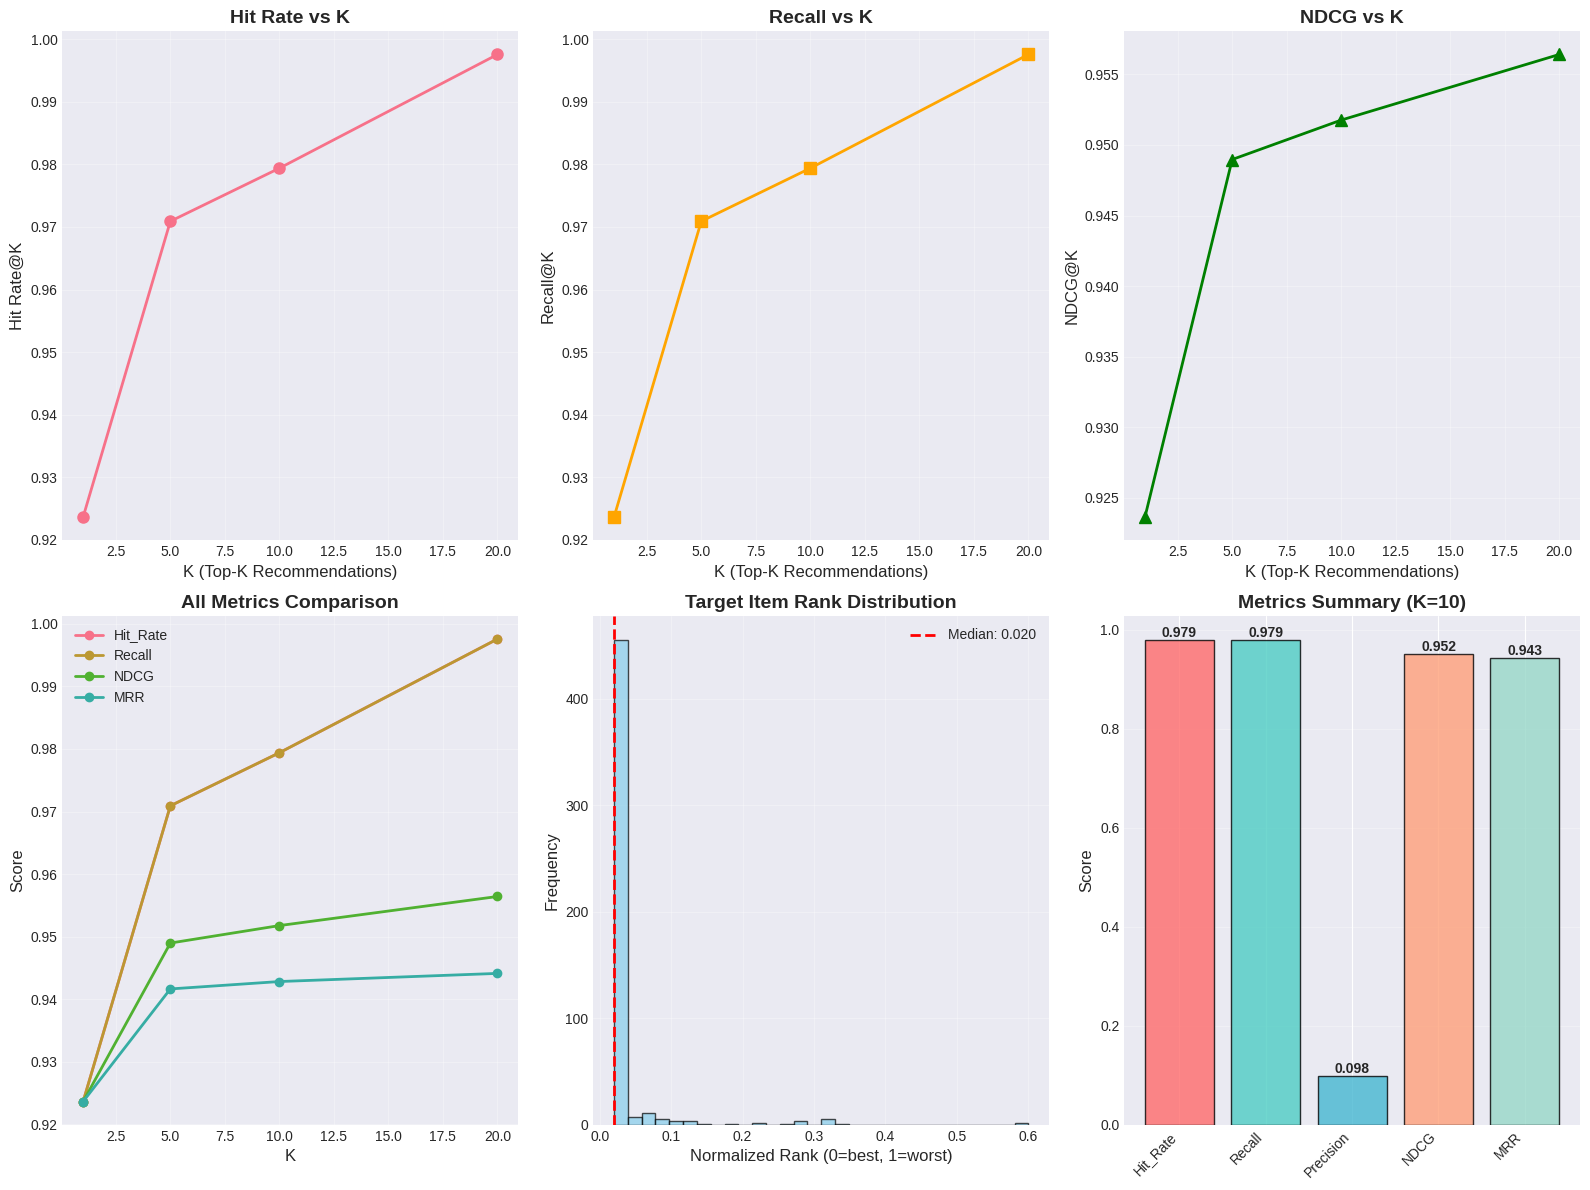


📋 EVALUATION SUMMARY

Model Performance Summary:
─────────────────────────────────────────────────────

🎯 Recommendation Accuracy (K=10):
   • Hit Rate@10:  97.94%
   • Recall@10:    97.94%
   • Precision@10: 0.0979
   • NDCG@10:      0.9518
   • MRR:          0.9428

🎯 Top-5 Performance:
   • Hit Rate@5:   97.09%
   • Recall@5:     97.09%
   • NDCG@5:       0.9490

📊 Prediction Error:
   • RMSE:         0.9695
   • MAE:          0.9678

📈 Dataset Info:
   • Test Examples: 825
   • Products:      49
   • Users:         961

─────────────────────────────────────────────────────

💡 Interpretation:
   • Hit Rate: % of times target item appears in top-K
   • Recall: Same as hit rate for single target
   • NDCG: Normalized discounted cumulative gain (position matters)
   • MRR: Mean reciprocal rank (1/position of first match)
   • Higher is better for all metrics!


✅ EVALUATION COMPLETE!


In [ ]:
# =============================================================
# MODEL EVALUATION WITH METRICS & VISUALIZATIONS
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import pandas as pd
import os # Import os for path joining

print("="*80)
print("📊 MODEL EVALUATION & ANALYSIS")
print("="*80)

# Define paths (ensure these match your setup if different)
DATA_DIR = "/content/drive/MyDrive/dataset Json"
SPLITS_PATH = os.path.join(DATA_DIR, "splits_final1.pkl")

# =============================================================
# 1. LOAD TEST DATA
# =============================================================

print("\n📂 Loading test data...")

# Load splits
with open(SPLITS_PATH, "rb") as f:
    splits = pickle.load(f)

test_examples = splits.get("test", splits.get("test_examples", []))
print(f"Test examples: {len(test_examples)}")

# =============================================================
# 2. RECOMMENDATION ACCURACY METRICS
# =============================================================

def evaluate_recommendations(test_examples, top_k_list=[1, 5, 10, 20]):
    """
    Evaluate recommendation accuracy using:
    - Hit Rate (HR@K)
    - Recall@K
    - Precision@K
    - NDCG@K
    - MRR (Mean Reciprocal Rank)
    """

    print("\n" + "="*80)
    print("🎯 RECOMMENDATION ACCURACY METRICS")
    print("="*80)

    metrics = {k: {'hits': 0, 'recall': [], 'precision': [], 'ndcg': [], 'mrr': []}
               for k in top_k_list}

    total_valid = 0

    print("\nEvaluating on test set...")
    for idx, example in enumerate(test_examples):
        if idx % 100 == 0:
            print(f"  Progress: {idx}/{len(test_examples)}", end='\r')

        # Parse example
        if isinstance(example, tuple) and len(example) >= 3:
            user_id, seq, target = example[0], example[1], example[2]
        else:
            continue

        # Skip invalid targets
        if target == 0 or target is None:
            continue

        # Pad sequence
        seq = list(seq) if isinstance(seq, (list, tuple)) else [seq]
        seq = seq[-MAX_SEQ_LEN:]
        seq = [0] * (MAX_SEQ_LEN - len(seq)) + seq
        seq_tensor = torch.tensor([seq], dtype=torch.long).to(DEVICE)

        # Get predictions
        with torch.no_grad():
            logits, _, _ = model(seq_tensor, node_features, prod_feats, edge_index)
            logits = logits[0]
            logits[0] = -1e9  # Mask padding

            # Get top-K predictions
            scores, preds = torch.topk(logits, max(top_k_list))
            preds = preds.cpu().numpy()

        total_valid += 1

        # Calculate metrics for each K
        for k in top_k_list:
            top_k_preds = preds[:k]

            # Hit Rate
            if target in top_k_preds:
                metrics[k]['hits'] += 1

                # MRR - position of first relevant item
                rank = np.where(top_k_preds == target)[0][0] + 1
                metrics[k]['mrr'].append(1.0 / rank)

                # NDCG
                dcg = 1.0 / np.log2(rank + 1)
                idcg = 1.0 / np.log2(2)  # Ideal: target at position 1
                metrics[k]['ndcg'].append(dcg / idcg)
            else:
                metrics[k]['mrr'].append(0.0)
                metrics[k]['ndcg'].append(0.0)

            # Recall & Precision (for single target, they're the same)
            recall = 1.0 if target in top_k_preds else 0.0
            precision = 1.0 / k if target in top_k_preds else 0.0

            metrics[k]['recall'].append(recall)
            metrics[k]['precision'].append(precision)

    print(f"\nEvaluation complete! Valid examples: {total_valid})")

    # Compute final metrics
    results = {}
    for k in top_k_list:
        results[k] = {
            'Hit_Rate': metrics[k]['hits'] / total_valid if total_valid > 0 else 0,
            'Recall': np.mean(metrics[k]['recall']),
            'Precision': np.mean(metrics[k]['precision']),
            'NDCG': np.mean(metrics[k]['ndcg']),
            'MRR': np.mean(metrics[k]['mrr'])
        }

    return results, total_valid


# Run evaluation
results, total_valid = evaluate_recommendations(test_examples, top_k_list=[1, 5, 10, 20])

# Display results
print("\n" + "="*80)
print("📈 RESULTS")
print("="*80)

results_df = pd.DataFrame(results).T
print("\n", results_df.round(4))

# =============================================================
# 3. PREDICTION ERROR METRICS (RMSE, MAE)
# =============================================================

print("\n" + "="*80)
print("📊 PREDICTION ERROR METRICS")
print("="*80)

def evaluate_prediction_error(test_examples, sample_size=500):
    """
    Evaluate prediction error using RMSE and MAE
    Treats this as a ranking problem with normalized scores
    """

    actual_ranks = []
    predicted_ranks = []

    print(f"\nEvaluating on {min(sample_size, len(test_examples))} examples...")

    for idx, example in enumerate(test_examples[:sample_size]):
        if idx % 50 == 0:
            print(f"  Progress: {idx}/{min(sample_size, len(test_examples))}", end='\r')

        if isinstance(example, tuple) and len(example) >= 3:
            user_id, seq, target = example[0], example[1], example[2]
        else:
            continue

        if target == 0 or target is None:
            continue

        seq = list(seq) if isinstance(seq, (list, tuple)) else [seq]
        seq = seq[-MAX_SEQ_LEN:]
        seq = [0] * (MAX_SEQ_LEN - len(seq)) + seq
        seq_tensor = torch.tensor([seq], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
            logits, _, _ = model(seq_tensor, node_features, prod_feats, edge_index)
            logits = logits[0].cpu().numpy()
            logits[0] = -1e9

        # Get rank of target item
        sorted_indices = np.argsort(-logits)
        target_rank = np.where(sorted_indices == target)[0]

        if len(target_rank) > 0:
            target_rank = target_rank[0] + 1  # 1-indexed

            # Normalize ranks to [0, 1]
            actual_ranks.append(1.0)  # Ideal rank = 1
            predicted_ranks.append(target_rank / len(logits))

    print(f"\n\nValid predictions: {len(actual_ranks)}")

    if len(actual_ranks) > 0:
        actual = np.array(actual_ranks)
        predicted = np.array(predicted_ranks)

        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        print(f"\n📊 RMSE (Root Mean Squared Error): {rmse:.4f}")
        print(f"📊 MAE (Mean Absolute Error): {mae:.4f}")
        print(f"📊 Average Predicted Rank: {predicted.mean():.4f}")
        print(f"📊 Median Predicted Rank: {np.median(predicted):.4f}")

        return rmse, mae, actual, predicted

    return None, None, None, None

rmse, mae, actual, predicted = evaluate_prediction_error(test_examples, sample_size=500)

# =============================================================
# 4. VISUALIZATIONS
# =============================================================

print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig = plt.figure(figsize=(16, 12))

# Plot 1: Hit Rate vs K
ax1 = plt.subplot(2, 3, 1)
k_values = list(results.keys())
hit_rates = [results[k]['Hit_Rate'] for k in k_values]
plt.plot(k_values, hit_rates, marker='o', linewidth=2, markersize=8)
plt.xlabel('K (Top-K Recommendations)', fontsize=12)
plt.ylabel('Hit Rate@K', fontsize=12)
plt.title('Hit Rate vs K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 2: Recall@K
ax2 = plt.subplot(2, 3, 2)
recalls = [results[k]['Recall'] for k in k_values]
plt.plot(k_values, recalls, marker='s', linewidth=2, markersize=8, color='orange')
plt.xlabel('K (Top-K Recommendations)', fontsize=12)
plt.ylabel('Recall@K', fontsize=12)
plt.title('Recall vs K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 3: NDCG@K
ax3 = plt.subplot(2, 3, 3)
ndcgs = [results[k]['NDCG'] for k in k_values]
plt.plot(k_values, ndcgs, marker='^', linewidth=2, markersize=8, color='green')
plt.xlabel('K (Top-K Recommendations)', fontsize=12)
plt.ylabel('NDCG@K', fontsize=12)
plt.title('NDCG vs K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 4: All metrics comparison
ax4 = plt.subplot(2, 3, 4)
metrics_to_plot = ['Hit_Rate', 'Recall', 'NDCG', 'MRR']
for metric in metrics_to_plot:
    values = [results[k][metric] for k in k_values]
    plt.plot(k_values, values, marker='o', linewidth=2, label=metric)
plt.xlabel('K', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('All Metrics Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Rank distribution (if we have prediction data)
ax5 = plt.subplot(2, 3, 5)
if predicted is not None:
    plt.hist(predicted, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Normalized Rank (0=best, 1=worst)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Target Item Rank Distribution', fontsize=14, fontweight='bold')
    plt.axvline(np.median(predicted), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(predicted):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 6: Metrics summary bar chart
ax6 = plt.subplot(2, 3, 6)
k_10_metrics = results[10]  # Focus on K=10
metric_names = list(k_10_metrics.keys())
metric_values = list(k_10_metrics.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Score', fontsize=12)
plt.title('Metrics Summary (K=10)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✅ Plots saved as 'model_evaluation.png'")
plt.show()

# =============================================================
# 5. SUMMARY REPORT
# =============================================================

print("\n" + "="*80)
print("📋 EVALUATION SUMMARY")
print("="*80)

# Prepare display strings for RMSE and MAE
rmse_display = f"{rmse:.4f}" if rmse is not None else "N/A"
mae_display = f"{mae:.4f}" if mae is not None else "N/A"

print(f"""
Model Performance Summary:
─────────────────────────────────────────────────────

🎯 Recommendation Accuracy (K=10):
   • Hit Rate@10:  {results[10]['Hit_Rate']:.2%}
   • Recall@10:    {results[10]['Recall']:.2%}
   • Precision@10: {results[10]['Precision']:.4f}
   • NDCG@10:      {results[10]['NDCG']:.4f}
   • MRR:          {results[10]['MRR']:.4f}

🎯 Top-5 Performance:
   • Hit Rate@5:   {results[5]['Hit_Rate']:.2%}
   • Recall@5:     {results[5]['Recall']:.2%}
   • NDCG@5:       {results[5]['NDCG']:.4f}

📊 Prediction Error:
   • RMSE:         {rmse_display}
   • MAE:          {mae_display}

📈 Dataset Info:
   • Test Examples: {total_valid}
   • Products:      {num_items}
   • Users:         {len(user2idx)}

─────────────────────────────────────────────────────

💡 Interpretation:
   • Hit Rate: % of times target item appears in top-K
   • Recall: Same as hit rate for single target
   • NDCG: Normalized discounted cumulative gain (position matters)
   • MRR: Mean reciprocal rank (1/position of first match)
   • Higher is better for all metrics!

""")

print("="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)